## Imports & Config

In [1]:
import os
import math
import time
import random
import json
import warnings
import csv
from pathlib import Path
from contextlib import nullcontext
from typing import Optional, List
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

from sklearn.model_selection import GroupShuffleSplit
from collections import Counter

try:
    from fastdtw import fastdtw
except ImportError:
    fastdtw = None

warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# Paths
PROC_META = "./proc/processed_metadata.csv"
FEATURE_DIR = "./features/pose_data"
GLOBAL_STATS_PATH = "./proc/global_stats.npz"
OUT_DIR = "./runs"
os.makedirs(OUT_DIR, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

if not os.path.exists(GLOBAL_STATS_PATH):
    print("⚠️ Missing global_stats.npz. Will compute from processed metadata if available.")

🖥️  Device: cuda
   GPU: NVIDIA GeForce RTX 3050 Laptop GPU
   Memory: 4.3 GB


In [2]:
CFG = {
    "seq_len": 64,
    "input_dim": 540,
    "proj_dim": 160,
    "rnn_hidden": 160,
    "rnn_layers": 2,
    "attn_heads": 4,
    "embed_dim": 256,
    "encoder_layers": 4,
    "encoder_ff_dim": 512,
    "encoder_dropout": 0.1,
    "batch_size": 8,
    "epochs": 100,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "temperature": 0.07,
    "confidence_temperature": 0.12,
    "sim_threshold": 0.58,
    "sim_margin": 0.10,
    "motion_floor": 7.5e-4,
    "val_split": 0.15,
    "patience": 40,
    "num_workers": 4,
    "grad_accum_steps": 2,
    "grad_clip": 1.0,
    "scheduler_t0": 40,
    "scheduler_tmult": 1,
    "scheduler_eta_min_scale": 0.2,
    "drop_prob": 0.10,
    "time_warp": 0.15,
    "noise_sigma": 0.012,
    "frame_dropout": 0.12,
    "temporal_shift": 4,
    "prototype_min_clips": 2,
    "prototype_topk": 5,
    "masked_frame_ratio": 0.15,
    "mask_loss_weight": 0.2,
    "label_smoothing": 0.1,
    "dtw": {
        "enabled": True,
        "radius": 6,
        "alpha": 0.65,
        "lambda": 0.002,
        "topk": 5
    },
    "retrieval_eval_every": 5,
    "retrieval_batch_size": 32,
    "decoder_max_len": 64,
    "decoder_eval_every": 1,
    "decoder_eval_samples": 5,
    "beam_size": 4,
    "beam_length_penalty": 0.8,
    "global_stats_path": GLOBAL_STATS_PATH,
    "device": device
}

print("📋 Configuration:")
for k, v in CFG.items():
    print(f"   {k}: {v}")

📋 Configuration:
   seq_len: 64
   input_dim: 540
   proj_dim: 160
   rnn_hidden: 160
   rnn_layers: 2
   attn_heads: 4
   embed_dim: 256
   encoder_layers: 4
   encoder_ff_dim: 512
   encoder_dropout: 0.1
   batch_size: 8
   epochs: 100
   lr: 0.0001
   weight_decay: 1e-05
   temperature: 0.07
   confidence_temperature: 0.12
   sim_threshold: 0.58
   sim_margin: 0.1
   motion_floor: 0.00075
   val_split: 0.15
   patience: 40
   num_workers: 4
   grad_accum_steps: 2
   grad_clip: 1.0
   scheduler_t0: 40
   scheduler_tmult: 1
   scheduler_eta_min_scale: 0.2
   drop_prob: 0.1
   time_warp: 0.15
   noise_sigma: 0.012
   frame_dropout: 0.12
   temporal_shift: 4
   prototype_min_clips: 2
   prototype_topk: 5
   masked_frame_ratio: 0.15
   mask_loss_weight: 0.2
   label_smoothing: 0.1
   dtw: {'enabled': True, 'radius': 6, 'alpha': 0.65, 'lambda': 0.002, 'topk': 5}
   retrieval_eval_every: 5
   retrieval_batch_size: 32
   decoder_max_len: 64
   decoder_eval_every: 1
   decoder_eval_samples: 

In [3]:
print("\n📊 Loading global normalization stats...")

def compute_and_save_global_stats(meta_path: str, stats_path: str) -> None:
    """Compute dataset-wide mean and std so inference can normalize inputs."""
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"Processed metadata missing at {meta_path}.")
    df = pd.read_csv(meta_path)
    if df.empty:
        raise ValueError("Processed metadata is empty; cannot compute global stats.")

    total_frames = 0
    sum_feats = None
    sum_sq_feats = None
    seq_lengths = []
    motion_means = []
    skipped_files = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Computing stats"):
        feat_path = getattr(row, "feature_path", None)
        if not feat_path or not os.path.exists(feat_path):
            skipped_files.append(str(feat_path))
            continue
        try:
            feat_arr = np.load(feat_path).astype(np.float32)
        except Exception as exc:
            skipped_files.append(f"{feat_path} :: {exc}")
            continue
        if feat_arr.ndim != 2 or feat_arr.shape[0] == 0:
            continue
        if sum_feats is None:
            feat_dim = feat_arr.shape[1]
            sum_feats = np.zeros(feat_dim, dtype=np.float64)
            sum_sq_feats = np.zeros(feat_dim, dtype=np.float64)

        total_frames += feat_arr.shape[0]
        sum_feats += feat_arr.sum(axis=0)
        sum_sq_feats += (feat_arr ** 2).sum(axis=0)
        seq_lengths.append(feat_arr.shape[0])
        if hasattr(row, "motion_mean") and not pd.isna(row.motion_mean):
            motion_means.append(float(row.motion_mean))

    if skipped_files:
        print(f"   ⚠️ Skipped {len(skipped_files)} feature files while building stats.")
    if total_frames == 0 or sum_feats is None:
        raise ValueError("No valid frames available to compute global stats.")

    feature_mean = sum_feats / total_frames
    feature_var = sum_sq_feats / total_frames - feature_mean ** 2
    feature_std = np.sqrt(np.maximum(feature_var, 1e-8))

    payload = {
        "feature_mean": feature_mean.astype(np.float32),
        "feature_std": feature_std.astype(np.float32),
        "seq_lengths": np.array(seq_lengths, dtype=np.int32),
        "motion_means": np.array(motion_means, dtype=np.float32)
    }
    np.savez(stats_path, **payload)
    print(f"   ✅ Saved stats to {stats_path}")

if not os.path.exists(CFG['global_stats_path']):
    print("   ↳ Stats file missing; generating from processed metadata.")
    compute_and_save_global_stats(PROC_META, CFG['global_stats_path'])

stats_blob = np.load(CFG['global_stats_path'])
GLOBAL_MEAN = stats_blob['feature_mean'].astype(np.float32)
GLOBAL_STD = stats_blob['feature_std'].astype(np.float32)
SEQ_LENGTHS = stats_blob.get('seq_lengths', np.array([], dtype=np.int32))
MOTION_MEANS = stats_blob.get('motion_means', np.array([], dtype=np.float32))

print(f"   Feature mean/std loaded with shape: {GLOBAL_MEAN.shape}")
if SEQ_LENGTHS.size:
    print(f"   Avg frames: {SEQ_LENGTHS.mean():.1f} | 95th pct: {np.percentile(SEQ_LENGTHS, 95):.1f}")
if MOTION_MEANS.size:
    print(f"   Median motion mean: {np.median(MOTION_MEANS):.4f}")


📊 Loading global normalization stats...
   Feature mean/std loaded with shape: (540,)
   Avg frames: 220.7 | 95th pct: 378.0
   Median motion mean: 2.0506


In [4]:
print("\n📊 Loading metadata...")
meta = pd.read_csv(PROC_META)
print(f"   Total samples: {len(meta)}")
print(f"   Columns: {meta.columns.tolist()}")

# Validate required columns
required_cols = [
    'video_file',
    'feature_path',
    'sentence_id',
    'num_frames',
    'motion_mean',
    'motion_p95',
    'mean_visibility'
]
missing = [col for col in required_cols if col not in meta.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Filter obvious low-motion clips
before_filter = len(meta)
meta = meta[meta['motion_mean'] >= CFG['motion_floor']].reset_index(drop=True)
filtered_out = before_filter - len(meta)
if filtered_out:
    print(f"   Removed {filtered_out} low-motion clips (< {CFG['motion_floor']:.2e})")

# Check for missing files
print("\n🔍 Validating feature files...")
missing_files = []
for idx, row in meta.iterrows():
    if not os.path.exists(row['feature_path']):
        missing_files.append(row['feature_path'])

if missing_files:
    print(f"⚠️  Warning: {len(missing_files)} files not found")
    meta = meta[meta['feature_path'].apply(os.path.exists)].reset_index(drop=True)
    print(f"   Proceeding with {len(meta)} valid samples")

# Sentence distribution
sentence_counts = meta['sentence_id'].value_counts()
print(f"\n📈 Dataset statistics:")
print(f"   Unique sentences: {meta['sentence_id'].nunique()}")
print(f"   Videos per sentence (avg): {len(meta) / meta['sentence_id'].nunique():.2f}")
print(f"   Min videos per sentence: {sentence_counts.min()}")
print(f"   Max videos per sentence: {sentence_counts.max()}")
print(f"   Median motion mean: {meta['motion_mean'].median():.4f}")
print(f"   Mean visibility: {meta['mean_visibility'].mean():.2f}")

meta.head()


📊 Loading metadata...
   Total samples: 1482
   Columns: ['video_file', 'feature_path', 'num_frames', 'frame_feature_dim', 'detection_ratio', 'mean_visibility', 'motion_mean', 'motion_p50', 'motion_p95', 'motion_max', 'sentence_id', 'sentence', 'category', 'text_variations']

🔍 Validating feature files...



📈 Dataset statistics:
   Unique sentences: 1307
   Videos per sentence (avg): 1.13
   Min videos per sentence: 1
   Max videos per sentence: 3
   Median motion mean: 2.0506
   Mean visibility: 0.71


,video_file,feature_path,num_frames,frame_feature_dim,detection_ratio,mean_visibility,motion_mean,motion_p50,motion_p95,motion_max,sentence_id,sentence,category,text_variations
0,6C.mp4,./features/pose_data/6C.npy,204,540,1.0,0.634450,5.189858,1.028685,21.248947,21.563328,6,Where is the waiting area?,General hospital interactions,"[""Where is the waiting area?"", ""Could you tell..."
1,7A.mp4,./features/pose_data/7A.npy,133,540,1.0,0.710908,4.331751,1.772263,17.325459,25.666006,7,What floor is the pediatric ward on?,General hospital interactions,"[""What floor is the pediatric ward on?"", ""Coul..."
2,12C.mp4,./features/pose_data/12C.npy,280,540,1.0,0.681588,1.026546,0.642750,1.785352,21.628674,12,What are the visiting hours?,General hospital interactions,"[""What are the visiting hours?"", ""What are the..."
3,13D.mp4,./features/pose_data/13D.npy,87,540,1.0,0.743295,2.994266,0.952077,18.779730,19.443213,13,Can I see the doctor now?,General hospital interactions,"[""Can I see the doctor now?"", ""May I see the d..."
4,14D.mp4,./features/pose_data/14D.npy,194,540,1.0,0.741099,1.963881,0.752932,17.932907,20.714615,14,Is this the maternity ward?,General hospital interactions,"[""Is this the maternity ward?"", ""Could you tel..."


In [5]:
def normalize_with_stats(seq, mean_vec, std_vec):
    """Normalize features using global stats."""
    return (seq - mean_vec) / std_vec


def random_time_crop(seq, target_len):
    """Random crop to target length."""
    total = seq.shape[0]
    if total <= target_len:
        return seq
    start = random.randint(0, total - target_len)
    return seq[start:start + target_len]


def center_time_crop(seq, target_len):
    """Center crop to target length."""
    total = seq.shape[0]
    if total <= target_len:
        return seq
    start = (total - target_len) // 2
    return seq[start:start + target_len]


def random_time_warp(seq, max_warp=0.1):
    """Time warping via linear resampling."""
    total = seq.shape[0]
    factor = 1.0 + random.uniform(-max_warp, max_warp)
    new_total = max(1, int(round(total * factor)))
    idxs = np.linspace(0, total - 1, new_total)
    lo = np.floor(idxs).astype(int)
    hi = np.clip(lo + 1, 0, total - 1)
    w = idxs - lo
    resampled = (1.0 - w[:, None]) * seq[lo] + w[:, None] * seq[hi]
    return resampled.astype(np.float32)


def random_frame_dropout(seq, drop_prob=0.1):
    """Randomly drop frames to simulate jitter."""
    if seq.shape[0] <= 2 or drop_prob <= 0.0:
        return seq
    mask = np.random.rand(seq.shape[0]) > drop_prob
    if not mask.any():
        mask[random.randrange(seq.shape[0])] = True
    return seq[mask]


def temporal_shift(seq, max_shift=3):
    """Temporal shift by rolling sequence."""
    if max_shift <= 0:
        return seq
    shift = random.randint(-max_shift, max_shift)
    if shift == 0:
        return seq
    return np.roll(seq, shift, axis=0)


def add_noise(seq, sigma=0.01):
    """Add Gaussian noise."""
    if sigma <= 0:
        return seq
    return seq + np.random.normal(0, sigma, seq.shape).astype(np.float32)


def random_rotation(seq, max_angle=15):
    """
    Apply random Y-axis rotation to 3D coordinates.
    Assumes features are flattened [x, y, z, ...].
    """
    if max_angle <= 0:
        return seq
    
    theta = np.radians(random.uniform(-max_angle, max_angle))
    c, s = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([
        [c, 0, s],
        [0, 1, 0],
        [-s, 0, c]
    ], dtype=np.float32)

    # Reshape to (T, N_landmarks, 3)
    # We need to know the structure. 
    # Based on preprocessing: 
    # POSE (33*4), HANDS (2*21*3), FACE (94*3)
    # Pose has visibility (x,y,z,v), others are (x,y,z)
    
    T, D = seq.shape
    out = seq.copy()
    
    # 1. Pose (33 landmarks * 4) -> indices 0..132
    # We only rotate x,y,z. Visibility is at index 3, 7, 11...
    pose_dim = 33 * 4
    pose_xyz = out[:, :pose_dim].reshape(T, 33, 4)
    # Rotate xyz
    pose_xyz[..., :3] = np.dot(pose_xyz[..., :3], rotation_matrix.T)
    out[:, :pose_dim] = pose_xyz.reshape(T, -1)
    
    # 2. Hands (2 * 21 * 3) -> indices 132..258
    hands_start = pose_dim
    hands_dim = 2 * 21 * 3
    hands_end = hands_start + hands_dim
    
    hands_xyz = out[:, hands_start:hands_end].reshape(T, -1, 3)
    hands_xyz = np.dot(hands_xyz, rotation_matrix.T)
    out[:, hands_start:hands_end] = hands_xyz.reshape(T, -1)
    
    # 3. Face (94 * 3) -> indices 258..540
    face_start = hands_end
    face_xyz = out[:, face_start:].reshape(T, -1, 3)
    face_xyz = np.dot(face_xyz, rotation_matrix.T)
    out[:, face_start:] = face_xyz.reshape(T, -1)
    
    return out


def compute_motion_energy(frames: np.ndarray) -> np.ndarray:
    """Compute per-frame motion energy from deltas."""
    if frames.shape[0] == 0:
        return np.zeros((0,), dtype=np.float32)
    pose_xyz = frames[:, :33 * 4].reshape(frames.shape[0], 33, 4)[..., :3]
    pose_xyz = pose_xyz.reshape(frames.shape[0], -1)
    hands = frames[:, 33 * 4:33 * 4 + 2 * 21 * 3]
    face = frames[:, 33 * 4 + 2 * 21 * 3:]
    coords = np.concatenate([pose_xyz, hands, face], axis=1)
    diffs = np.diff(coords, axis=0, prepend=coords[:1])
    return np.linalg.norm(diffs, axis=1).astype(np.float32)


print("✅ Augmentation helpers ready (with Rotation)")

✅ Augmentation helpers ready (with Rotation)


In [6]:
from torch.nn.utils.rnn import pad_sequence

class SignDataset(Dataset):
    """Contrastive dataset yielding two augmented temporal views + tokenized text."""

    def __init__(
        self,
        meta_df,
        tokenizer,
        seq_len=64,
        expected_dim=540,
        global_mean=None,
        global_std=None,
        augment=True,
        cfg=None
    ):
        self.meta = meta_df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.expected_dim = expected_dim
        self.augment = augment
        self.global_mean = (global_mean if global_mean is not None else np.zeros(expected_dim, dtype=np.float32))
        self.global_std = (global_std if global_std is not None else np.ones(expected_dim, dtype=np.float32))
        self.cfg = cfg or {}
        self.time_warp = self.cfg.get('time_warp', 0.0)
        self.frame_dropout = self.cfg.get('frame_dropout', 0.0)
        self.noise_sigma = self.cfg.get('noise_sigma', 0.0)
        self.temporal_shift_max = self.cfg.get('temporal_shift', 0)
        self.rotation_angle = self.cfg.get('rotation_angle', 15)
        self.pad_token_id = getattr(tokenizer, 'pad_token_id', 0)

        # Parse text variations
        self.text_variations = {}
        if 'text_variations' in self.meta.columns:
            for idx, row in self.meta.iterrows():
                try:
                    if pd.notna(row['text_variations']):
                        vars_list = json.loads(row['text_variations'])
                        if isinstance(vars_list, list) and vars_list:
                            self.text_variations[row['sentence_id']] = vars_list
                except:
                    pass

    def __len__(self):
        return len(self.meta)

    def load_and_validate(self, path):
        """Load .npy with validation."""
        try:
            arr = np.load(path).astype(np.float32)
            if arr.ndim != 2:
                raise ValueError(f"Expected 2D array, got shape {arr.shape}")
            if arr.shape[1] != self.expected_dim:
                raise ValueError(
                    f"Feature dim mismatch: expected {self.expected_dim}, got {arr.shape[1]}"
                )
            return arr
        except Exception as exc:
            raise RuntimeError(f"Error loading {path}: {exc}")

    def augment_view(self, seq: np.ndarray, mode='standard') -> np.ndarray:
        """Apply stochastic augmentations based on view mode."""
        out = seq.copy()
        
        # Common augmentations
        if random.random() < 0.6 and self.time_warp > 0:
            out = random_time_warp(out, max_warp=self.time_warp)
        if random.random() < 0.5 and self.frame_dropout > 0:
            out = random_frame_dropout(out, drop_prob=self.frame_dropout)
        
        # View-specific augmentations
        if mode == 'view1': # Anchor: Noise
            if random.random() < 0.5 and self.noise_sigma > 0:
                out = add_noise(out, sigma=self.noise_sigma)
        elif mode == 'view2': # Positive: Rotation
            if random.random() < 0.8 and self.rotation_angle > 0:
                out = random_rotation(out, max_angle=self.rotation_angle)
                
        return out

    def preprocess(self, arr, mode='standard'):
        """Preprocess sequence: augment, normalize, pad/crop."""
        seq = arr.astype(np.float32)

        if self.augment:
            seq = self.augment_view(seq, mode=mode)
        else:
            seq = center_time_crop(seq, min(seq.shape[0], self.seq_len))

        if seq.shape[0] > self.seq_len:
            seq = random_time_crop(seq, self.seq_len) if self.augment else center_time_crop(seq, self.seq_len)

        seq = normalize_with_stats(seq, self.global_mean, self.global_std)

        if seq.shape[0] < self.seq_len:
            pad = np.zeros((self.seq_len - seq.shape[0], seq.shape[1]), dtype=np.float32)
            seq = np.vstack([seq, pad])
        elif seq.shape[0] > self.seq_len:
            seq = seq[:self.seq_len]

        return seq.astype(np.float32)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        try:
            arr = self.load_and_validate(row['feature_path'])
            
            # Dual-View Splitting
            if arr.shape[0] < 4:
                view1_raw = arr
                view2_raw = arr
            else:
                view1_raw = arr[0::2]
                view2_raw = arr[1::2]
            
            view_a = self.preprocess(view1_raw, mode='view1')
            view_b = self.preprocess(view2_raw, mode='view2')
            
            # Text Labels
            sid = row['sentence_id']
            variations = self.text_variations.get(sid, [row['sentence']])
            
            # Select two different variations if possible
            if len(variations) >= 2:
                text_a, text_b = random.sample(variations, 2)
            else:
                text_a = variations[0]
                text_b = variations[0]

            # Tokenize text_a (Anchor Text)
            token_ids = self.tokenizer.encode(text_a)

            return {
                'a': torch.from_numpy(view_a),
                'b': torch.from_numpy(view_b),
                'label': idx,
                'sentence_id': int(sid),
                'text_a': text_a,
                'text_b': text_b,
                'token_ids': torch.tensor(token_ids, dtype=torch.long),
                'pad_token_id': self.pad_token_id,
                'idx': idx
            }
        except Exception as exc:
            print(f"⚠️  Error processing {row['video_file']}: {exc}")
            dummy = np.zeros((self.seq_len, self.expected_dim), dtype=np.float32)
            return {
                'a': torch.from_numpy(dummy),
                'b': torch.from_numpy(dummy),
                'label': -1,
                'sentence_id': -1,
                'text_a': "",
                'text_b': "",
                'token_ids': torch.tensor([self.pad_token_id], dtype=torch.long),
                'pad_token_id': self.pad_token_id,
                'idx': idx
            }


def collate_fn(batch):
    """Stack batch tensors and drop failed samples."""
    valid_batch = [item for item in batch if item['label'] != -1]
    if len(valid_batch) == 0:
        return None, None, None, None, None, None, None
    
    pad_id = valid_batch[0].get('pad_token_id', 0)
    
    a = torch.stack([item['a'] for item in valid_batch])
    b = torch.stack([item['b'] for item in valid_batch])
    labels = torch.tensor([item['label'] for item in valid_batch], dtype=torch.long)
    sentence_ids = torch.tensor([item['sentence_id'] for item in valid_batch], dtype=torch.long)
    
    text_a = [item['text_a'] for item in valid_batch]
    text_b = [item['text_b'] for item in valid_batch]
    
    # Pad token sequences
    token_ids = [item['token_ids'] for item in valid_batch]
    token_ids_padded = pad_sequence(token_ids, batch_first=True, padding_value=pad_id)
    
    return a, b, labels, sentence_ids, text_a, text_b, token_ids_padded


print("✅ Dataset class defined (Dual-View + Text Augmentation + Tokenization)")

✅ Dataset class defined (Dual-View + Text Augmentation + Tokenization)


In [7]:
class SimpleTokenizer:
    """Simple word-level tokenizer."""
    def __init__(self):
        self.token2id = {
            "<pad>": 0,
            "<sos>": 1,
            "<eos>": 2,
            "<unk>": 3
        }
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.vocab_size = 4

        # Handy shortcuts for downstream code
        self.pad_token_id = self.token2id["<pad>"]
        self.sos_token_id = self.token2id["<sos>"]
        self.eos_token_id = self.token2id["<eos>"]
        self.unk_token_id = self.token2id["<unk>"]

    def build_vocab(self, sentences):
        """Build vocabulary from list of sentences."""
        word_counts = Counter()
        for sent in sentences:
            words = self._tokenize(sent)
            word_counts.update(words)
        
        # Sort by frequency
        for word, _ in word_counts.most_common():
            if word not in self.token2id:
                idx = len(self.token2id)
                self.token2id[word] = idx
                self.id2token[idx] = word
        
        self.vocab_size = len(self.token2id)
        print(f"✅ Vocab built: {self.vocab_size} tokens")

    def _tokenize(self, text):
        """Basic preprocessing: lowercase and remove punctuation."""
        text = text.lower()
        # Simple punctuation removal
        for char in [',', '.', '?', '!', '"', "'"]:
            text = text.replace(char, '')
        return text.split()

    def encode(self, text, add_special_tokens=True) -> List[int]:
        """Convert text to list of IDs."""
        words = self._tokenize(text)
        ids = [self.token2id.get(w, self.unk_token_id) for w in words]
        if add_special_tokens:
            ids = [self.sos_token_id] + ids + [self.eos_token_id]
        return ids

    def decode(self, ids: List[int], skip_special_tokens=True):
        """Convert IDs back to text."""
        tokens = []
        for i in ids:
            token = self.id2token.get(i, "<unk>")
            if skip_special_tokens and token in ["<pad>", "<sos>", "<eos>"]:
                continue
            tokens.append(token)
        return " ".join(tokens)

# Initialize and build tokenizer
tokenizer = SimpleTokenizer()

# Collect all sentences for vocab building
all_sentences = meta['sentence'].tolist()
# Add variations if available
if os.path.exists("proc/sentence_variations.json"):
    with open("proc/sentence_variations.json", "r") as f:
        variations = json.load(f)
        for sent_list in variations.values():
            all_sentences.extend(sent_list)

tokenizer.build_vocab(all_sentences)
CFG['vocab_size'] = tokenizer.vocab_size
print(f"   Vocab size added to CFG: {CFG['vocab_size']}")

# Persist tokenizer vocab for inference notebooks
vocab_path = Path(OUT_DIR) / "tokenizer_vocab.json"
vocab_path.parent.mkdir(parents=True, exist_ok=True)
with open(vocab_path, "w") as f:
    json.dump({"token2id": tokenizer.token2id}, f, indent=2)
print(f"   Tokenizer vocab saved to {vocab_path}")

✅ Vocab built: 4249 tokens
   Vocab size added to CFG: 4249
   Tokenizer vocab saved to runs/tokenizer_vocab.json


In [8]:
from torch.utils.data import Sampler
from collections import defaultdict

class ClassBalancedSampler(Sampler):
    """
    Sampler that ensures each batch contains at least K instances of each class.
    Useful for Supervised Contrastive Learning.
    """
    def __init__(self, data_source, batch_size, instances_per_class=2):
        self.data_source = data_source
        self.batch_size = batch_size
        self.instances_per_class = instances_per_class
        self.classes_per_batch = batch_size // instances_per_class
        
        # Group indices by sentence_id
        self.class_indices = defaultdict(list)
        for idx, row in data_source.iterrows():
            self.class_indices[row['sentence_id']].append(idx)
            
        self.classes = list(self.class_indices.keys())
        self.num_batches = len(data_source) // batch_size
        
    def __iter__(self):
        for _ in range(self.num_batches):
            batch = []
            # Select classes for this batch
            selected_classes = random.sample(self.classes, min(len(self.classes), self.classes_per_batch))
            
            for cls in selected_classes:
                indices = self.class_indices[cls]
                if len(indices) >= self.instances_per_class:
                    batch.extend(random.sample(indices, self.instances_per_class))
                else:
                    # Sample with replacement if not enough instances
                    batch.extend(random.choices(indices, k=self.instances_per_class))
            
            # Fill remaining slots if any
            while len(batch) < self.batch_size:
                cls = random.choice(self.classes)
                indices = self.class_indices[cls]
                batch.append(random.choice(indices))
                
            yield batch

    def __len__(self):
        return self.num_batches

print("\n🔀 Creating train/val split...")


train_aug_cfg = {
    'time_warp': CFG['time_warp'],
    'frame_dropout': CFG['frame_dropout'],
    'noise_sigma': CFG['noise_sigma'],
    'temporal_shift': CFG['temporal_shift'],
    'rotation_angle': 15,
}

# Group by sentence_id to ensure no data leakage
sentence_groups = meta.groupby('sentence_id').size()

print(f"   Sentences with 1 sample: {(sentence_groups == 1).sum()}")
print(f"   Sentences with 2+ samples: {(sentence_groups >= 2).sum()}")

splitter = GroupShuffleSplit(
    n_splits=1,
    test_size=CFG['val_split'],
    random_state=SEED
)

train_idx, val_idx = next(splitter.split(meta, groups=meta['sentence_id']))
train_meta = meta.iloc[train_idx].reset_index(drop=True)
val_meta = meta.iloc[val_idx].reset_index(drop=True)

print(f"\n📊 Split results:")
print(f"   Train: {len(train_meta)} videos, {train_meta['sentence_id'].nunique()} sentences")
print(f"   Val: {len(val_meta)} videos, {val_meta['sentence_id'].nunique()} sentences")
print(f"   Train motion median: {train_meta['motion_mean'].median():.4f}")
print(f"   Val motion median: {val_meta['motion_mean'].median():.4f}")

train_sentences = set(train_meta['sentence_id'])
val_sentences = set(val_meta['sentence_id'])
overlap = train_sentences & val_sentences

if overlap:
    print(f"⚠️  Warning: {len(overlap)} sentences appear in both train and val!")
else:
    print("✅ No sentence overlap between train and val")

train_ds = SignDataset(
    train_meta,
    tokenizer=tokenizer,
    seq_len=CFG['seq_len'],
    expected_dim=CFG['input_dim'],
    global_mean=GLOBAL_MEAN,
    global_std=GLOBAL_STD,
    augment=True,
    cfg={
        'time_warp': CFG['time_warp'],
        'frame_dropout': CFG['frame_dropout'],
        'noise_sigma': CFG['noise_sigma'],
        'temporal_shift': CFG['temporal_shift'],
        'rotation_angle': 15 # Enable rotation
    }
)

val_aug_cfg = {
    'time_warp': CFG['time_warp'] * 0.35,
    'frame_dropout': CFG['frame_dropout'] * 0.5,
    'noise_sigma': CFG['noise_sigma'] * 0.5,
    'temporal_shift': max(1, CFG['temporal_shift'] // 2),
    'rotation_angle': 0 # No rotation for val
}

val_ds = SignDataset(
    val_meta,
    tokenizer=tokenizer,
    seq_len=CFG['seq_len'],
    expected_dim=CFG['input_dim'],
    global_mean=GLOBAL_MEAN,
    global_std=GLOBAL_STD,
    augment=True,
    cfg=val_aug_cfg
)

# Use ClassBalancedSampler for training
train_sampler = ClassBalancedSampler(train_meta, CFG['batch_size'], instances_per_class=2)

train_loader = DataLoader(
    train_ds,
    batch_sampler=train_sampler, # Use batch_sampler
    num_workers=CFG['num_workers'],
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_workers'],
    collate_fn=collate_fn,
    pin_memory=True
)

print(f"\n✅ DataLoaders ready (with ClassBalancedSampler)")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")


🔀 Creating train/val split...
   Sentences with 1 sample: 1138
   Sentences with 2+ samples: 169

📊 Split results:
   Train: 1257 videos, 1110 sentences
   Val: 225 videos, 197 sentences
   Train motion median: 2.0700
   Val motion median: 1.9335
✅ No sentence overlap between train and val

✅ DataLoaders ready (with ClassBalancedSampler)
   Train batches: 157
   Val batches: 29


In [9]:
class FrameProjector(nn.Module):
    """Project per-frame features to a lower-dimensional representation."""

    def __init__(self, in_dim, proj_dim=160):
        super().__init__()
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, proj_dim)
        self.fc2 = nn.Linear(proj_dim, proj_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):  # (B, T, F)
        out = self.norm(x)
        out = self.act(self.fc1(out))
        out = self.dropout(out)
        out = self.act(self.fc2(out))
        return out


class TemporalEncoder(nn.Module):
    """Encode temporal sequence into a fixed embedding with attention pooling."""

    def __init__(self, in_dim, hidden=160, n_layers=2, embed_dim=256, attn_heads=4):
        super().__init__()
        self.gru = nn.GRU(
            in_dim,
            hidden,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.1 if n_layers > 1 else 0.0
        )
        self.attn_heads = attn_heads
        self.attn_key = nn.Linear(hidden * 2, hidden)
        self.attn_score = nn.Linear(hidden, attn_heads)
        self.attn_proj = nn.Linear(hidden * 2, embed_dim)
        
        # Projection for Seq2Seq context
        self.context_proj = nn.Linear(hidden * 2, embed_dim)
        
        self.post_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, return_sequence=False):  # (B, T, C)
        seq_out, _ = self.gru(x) # (B, T, 2*hidden)
        
        keys = torch.tanh(self.attn_key(seq_out))  # (B, T, hidden)
        attn_logits = self.attn_score(keys)  # (B, T, H)

        motion = torch.norm(x[:, 1:] - x[:, :-1], dim=-1, keepdim=True)
        motion = torch.cat([motion[:, :1], motion], dim=1)  # (B, T, 1)
        motion = (motion - motion.mean(dim=1, keepdim=True)) / (motion.std(dim=1, keepdim=True) + 1e-6)
        attn_logits = attn_logits + motion

        weights = torch.softmax(attn_logits, dim=1)  # (B, T, H)
        pooled = torch.sum(seq_out.unsqueeze(-2) * weights.unsqueeze(-1), dim=1)  # (B, H, 2*hidden)
        pooled = pooled.mean(dim=1)  # average across heads

        embedding = self.attn_proj(self.dropout(pooled))
        embedding = self.post_norm(embedding)
        embedding = nn.functional.normalize(embedding, dim=-1)
        
        if return_sequence:
            # Project seq_out to embed_dim for decoder usage
            context = self.context_proj(seq_out) # (B, T, embed_dim)
            return embedding, weights.mean(dim=2), context
            
        return embedding, weights.mean(dim=2)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class SignTranslationModel(nn.Module):
    """Seq2Seq model: Visual Encoder + Text Decoder."""

    def __init__(self, input_dim, vocab_size, proj_dim=160, hidden=160, n_layers=2, embed_dim=256, attn_heads=4):
        super().__init__()
        self.projector = FrameProjector(input_dim, proj_dim)
        self.encoder = TemporalEncoder(proj_dim, hidden, n_layers, embed_dim, attn_heads)
        
        # Decoder components
        self.tgt_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=attn_heads, dim_feedforward=embed_dim*4, dropout=0.1)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=2) # Start with 2 layers
        
        self.generator = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

    def encode_visual(self, x):
        """Encode visual sequence for Contrastive Loss."""
        proj = self.projector(x)
        embedding, attn_weights = self.encoder(proj)
        return embedding

    def encode_for_inference(self, x):
        """Encode visual sequence and return intermediates for analysis."""
        proj = self.projector(x)
        embedding, attn_weights, context = self.encoder(proj, return_sequence=True)
        return embedding, proj, attn_weights

    def forward(self, src, tgt, tgt_mask=None, tgt_pad_mask=None):
        """
        src: (B, T, F) - Visual input
        tgt: (B, L) - Text input (token IDs)
        """
        # 1. Encode Visual
        proj = self.projector(src)
        embedding, attn_weights, context = self.encoder(proj, return_sequence=True)
        # context: (B, T, embed_dim)
        
        # Prepare for Transformer (S, B, E)
        memory = context.permute(1, 0, 2) 
        
        # 2. Embed Text
        tgt_emb = self.tgt_embed(tgt).permute(1, 0, 2) # (L, B, E)
        tgt_emb = self.pos_encoder(tgt_emb)
        
        # 3. Decode
        output = self.decoder(
            tgt_emb, 
            memory, 
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_pad_mask
        ) # (L, B, E)
        
        # 4. Generate logits
        logits = self.generator(output.permute(1, 0, 2)) # (B, L, Vocab)
        
        return logits, embedding

    @torch.no_grad()
    def project_frames(self, x):
        return self.projector(x)


# Update CFG with vocab size if not present (handled by tokenizer cell)
vocab_size = CFG.get('vocab_size', 1000) # Default fallback

model = SignTranslationModel(
    input_dim=CFG['input_dim'],
    vocab_size=vocab_size,
    proj_dim=CFG['proj_dim'],
    hidden=CFG['rnn_hidden'],
    n_layers=CFG['rnn_layers'],
    embed_dim=CFG['embed_dim'],
    attn_heads=CFG['attn_heads']
).to(CFG['device'])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🤖 SignTranslationModel initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB (fp32)")


🤖 SignTranslationModel initialized
   Total parameters: 5,388,725
   Trainable parameters: 5,388,725
   Model size: ~21.6 MB (fp32)


In [10]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Loss: https://arxiv.org/abs/2004.11362"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """
        features: [2*B, dim] (concatenated views)
        labels: [2*B] (corresponding class labels)
        """
        device = features.device
        batch_size = features.shape[0]
        
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        # Contrastive loss
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )
        
        # Numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        # Mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # Compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-6)
        
        # Compute mean of log-likelihood over positive
        # Avoid division by zero if a sample has no positives (shouldn't happen with ClassBalancedSampler)
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-6)
        
        loss = -mean_log_prob_pos
        return loss.mean()

def generate_square_subsequent_mask(sz):
    """Generate causal mask for transformer decoder."""
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

@torch.no_grad()
def compute_embeddings(model, loader, device):
    """Compute embeddings for entire dataset"""
    model.eval()
    all_embs = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Computing embeddings", leave=False):
        if batch[0] is None:  # Skip failed batches
            continue
        
        # Unpack new batch structure
        a, b, labels, *_ = batch
        
        x = a.to(device, non_blocking=True)
        # Use encode_visual for embedding extraction
        emb = model.encode_visual(x)
        
        all_embs.append(emb.cpu())
        all_labels.append(labels)
    
    if len(all_embs) == 0:
        return None, None
    
    return torch.cat(all_embs), torch.cat(all_labels)

@torch.no_grad()
def evaluate_alignment(model, loader, device):
    """Measure how well paired augmentations align in embedding space."""
    model.eval()

    emb_a_chunks = []
    emb_b_chunks = []
    counts = 0

    for batch in tqdm(loader, desc="Evaluating", leave=False):
        if batch[0] is None:
            continue

        # Unpack new batch structure
        a, b, labels, *_ = batch
        
        a = a.to(device, non_blocking=True)
        b = b.to(device, non_blocking=True)

        # Use encode_visual for alignment check
        emb_a_chunks.append(model.encode_visual(a).cpu())
        emb_b_chunks.append(model.encode_visual(b).cpu())
        counts += a.size(0)

    if counts == 0:
        return {"inst_top1": 0.0, "pos_sim": 0.0, "neg_sim": 0.0}

    emb_a = torch.cat(emb_a_chunks)
    emb_b = torch.cat(emb_b_chunks)
    sims = emb_a @ emb_b.T

    top1 = (sims.argmax(dim=1) == torch.arange(sims.size(0))).float().mean().item()
    pos_sim = sims.diag().mean().item()

    if sims.size(0) > 1:
        mask = torch.eye(sims.size(0), dtype=torch.bool)
        hard_neg = sims.masked_fill(mask, -1.0).max(dim=1).values.mean().item()
    else:
        hard_neg = 0.0

    return {"inst_top1": top1, "pos_sim": pos_sim, "neg_sim": hard_neg}

print("✅ SupConLoss and Causal Masking defined")

✅ SupConLoss and Causal Masking defined


In [11]:
def _length_penalty(length: int, alpha: float) -> float:
    if alpha <= 0:
        return 1.0
    return ((5 + length) / 6) ** alpha


def _strip_special_tokens(seq: List[int], tokenizer) -> List[int]:
    cleaned: List[int] = []
    for tid in seq:
        if tid == tokenizer.sos_token_id:
            continue
        if tid == tokenizer.eos_token_id:
            break
        cleaned.append(tid)
    return cleaned


def _beam_search_single(
    model,
    memory: torch.Tensor,
    tokenizer,
    device,
    max_len: int,
    beam_size: int,
    length_penalty: float
) -> List[int]:
    bos = tokenizer.sos_token_id
    eos = tokenizer.eos_token_id
    beams = [(0.0, [bos], False)]
    finished: List[tuple[float, List[int]]] = []

    for _ in range(max_len):
        new_beams = []
        for logprob, seq, done in beams:
            if done:
                new_beams.append((logprob, seq, True))
                continue
            tgt = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            tgt_emb = model.tgt_embed(tgt).permute(1, 0, 2)
            tgt_emb = model.pos_encoder(tgt_emb)
            decoder_out = model.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
            logits = model.generator(decoder_out[-1].unsqueeze(0))
            log_probs = torch.log_softmax(logits.squeeze(0), dim=-1)
            topk = torch.topk(log_probs, k=min(beam_size, log_probs.numel()))
            top_values = topk.values.reshape(-1).tolist()
            top_indices = topk.indices.reshape(-1).tolist()
            for value, index in zip(top_values, top_indices):
                token_id = int(index)
                next_seq = seq + [token_id]
                next_done = token_id == eos
                next_logprob = logprob + float(value)
                new_beams.append((next_logprob, next_seq, next_done))
                if next_done:
                    finished.append((next_logprob, next_seq))
        if not new_beams:
            break
        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]
        if all(done for _, _, done in beams):
            break

    def _select(candidates: List[tuple[float, List[int]]]) -> List[int]:
        scored = [
            (score / _length_penalty(len(seq), length_penalty), seq)
            for score, seq in candidates
        ]
        return max(scored, key=lambda x: x[0])[1]

    if finished:
        return _select(finished)
    return _select([(score, seq) for score, seq, _ in beams])


@torch.no_grad()
def beam_search_decode_batch(
    model,
    src_batch: torch.Tensor,
    tokenizer,
    device,
    max_len: int = 64,
    beam_size: int = 4,
    length_penalty: float = 0.8
) -> List[List[int]]:
    model.eval()
    beam_size = max(1, beam_size)
    src_batch = src_batch.to(device, non_blocking=True)
    proj = model.projector(src_batch)
    _, _, context = model.encoder(proj, return_sequence=True)
    memory = context.permute(1, 0, 2)
    decoded: List[List[int]] = []
    for idx in range(src_batch.size(0)):
        sample_memory = memory[:, idx:idx + 1, :]
        best_seq = _beam_search_single(
            model,
            sample_memory,
            tokenizer,
            device,
            max_len=max_len,
            beam_size=beam_size,
            length_penalty=length_penalty
        )
        decoded.append(_strip_special_tokens(best_seq, tokenizer))
    return decoded


def tokens_to_sentence(tokenizer, token_ids: List[int]) -> str:
    return tokenizer.decode(token_ids, skip_special_tokens=True).strip()


def word_error_rate(reference: str, hypothesis: str) -> float:
    ref_words = reference.strip().split()
    hyp_words = hypothesis.strip().split()
    if not ref_words and not hyp_words:
        return 0.0
    if not ref_words:
        return float(len(hyp_words) > 0)
    dp = np.zeros((len(ref_words) + 1, len(hyp_words) + 1), dtype=np.int32)
    for i in range(len(ref_words) + 1):
        dp[i, 0] = i
    for j in range(len(hyp_words) + 1):
        dp[0, j] = j
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            cost = 0 if ref_words[i - 1] == hyp_words[j - 1] else 1
            dp[i, j] = min(
                dp[i - 1, j] + 1,
                dp[i, j - 1] + 1,
                dp[i - 1, j - 1] + cost
            )
    return float(dp[len(ref_words), len(hyp_words)] / max(len(ref_words), 1))


def simple_bleu_score(reference: str, hypothesis: str, max_n: int = 4) -> float:
    ref_tokens = reference.strip().split()
    hyp_tokens = hypothesis.strip().split()
    if not ref_tokens and not hyp_tokens:
        return 1.0
    if not hyp_tokens:
        return 0.0
    eps = 1e-9
    precisions = []
    for n in range(1, max_n + 1):
        if len(hyp_tokens) < n:
            precisions.append(eps)
            continue
        ref_counts = Counter(tuple(ref_tokens[i:i + n]) for i in range(max(len(ref_tokens) - n + 1, 0)))
        hyp_counts = Counter(tuple(hyp_tokens[i:i + n]) for i in range(len(hyp_tokens) - n + 1))
        overlap = sum(min(count, ref_counts.get(gram, 0)) for gram, count in hyp_counts.items())
        total = sum(hyp_counts.values())
        precisions.append((overlap + eps) / (total + eps))
    log_precision = sum(math.log(p) for p in precisions) / len(precisions)
    ref_len = len(ref_tokens)
    hyp_len = len(hyp_tokens)
    bp = 1.0 if hyp_len > ref_len else math.exp(1 - (ref_len / max(hyp_len, 1)))
    return float(bp * math.exp(log_precision))


@torch.no_grad()
def evaluate_decoder_generation(
    model,
    loader,
    tokenizer,
    device,
    max_samples: int = 32,
    max_len: int = 64,
    beam_size: int | None = None,
    length_penalty: float | None = None
) -> dict:
    model.eval()
    samples = []
    processed = 0
    beam = beam_size or CFG.get('beam_size', 1)
    penalty = length_penalty if length_penalty is not None else CFG.get('beam_length_penalty', 0.0)

    for batch in loader:
        if batch[0] is None:
            continue
        visuals = batch[0]
        token_ids = batch[-1]
        decoded = beam_search_decode_batch(
            model,
            visuals,
            tokenizer,
            device,
            max_len=max_len,
            beam_size=beam,
            length_penalty=penalty
        )
        for ref_ids, hyp_tokens in zip(token_ids, decoded):
            reference = tokens_to_sentence(tokenizer, ref_ids.cpu().tolist())
            hypothesis = tokens_to_sentence(tokenizer, hyp_tokens)
            wer = word_error_rate(reference, hypothesis)
            bleu = simple_bleu_score(reference, hypothesis)
            samples.append({
                'reference': reference,
                'prediction': hypothesis,
                'wer': wer,
                'bleu': bleu
            })
            processed += 1
            if processed >= max_samples:
                break
        if processed >= max_samples:
            break

    if not samples:
        return {
            'decoder_wer': float('nan'),
            'decoder_bleu': float('nan'),
            'decoder_exact': float('nan'),
            'samples': []
        }

    avg_wer = float(np.mean([s['wer'] for s in samples]))
    avg_bleu = float(np.mean([s['bleu'] for s in samples]))
    exact_match = float(np.mean([1.0 if s['reference'] == s['prediction'] else 0.0 for s in samples]))
    return {
        'decoder_wer': avg_wer,
        'decoder_bleu': avg_bleu,
        'decoder_exact': exact_match,
        'samples': samples
    }


print("✅ Decoder helpers (beam search + text metrics) ready")

✅ Decoder helpers (beam search + text metrics) ready


In [12]:
@torch.no_grad()
def evaluate_sentence_retrieval(model, meta_df, cfg, global_mean, global_std, tokenizer, batch_size=32):
    """Measure retrieval accuracy across the validation set."""
    model.eval()
    if meta_df.empty:
        return {
            "ret_top1": float("nan"),
            "ret_mrr": float("nan"),
            "pos_sim": float("nan"),
            "neg_sim": float("nan")
        }

    eval_ds = SignDataset(
        meta_df,
        tokenizer=tokenizer,
        seq_len=cfg['seq_len'],
        expected_dim=cfg['input_dim'],
        global_mean=global_mean,
        global_std=global_std,
        augment=False
    )

    sequences = []
    sentence_ids = []
    for row in meta_df.itertuples():
        try:
            arr = eval_ds.load_and_validate(row.feature_path)
            # Preprocess without augmentation (augment=False in init)
            seq = eval_ds.preprocess(arr)
            sequences.append(seq)
            sentence_ids.append(int(row.sentence_id))
        except Exception as exc:
            print(f"⚠️  Retrieval eval skipped {row.video_file}: {exc}")

    if not sequences:
        return {
            "ret_top1": float("nan"),
            "ret_mrr": float("nan"),
            "pos_sim": float("nan"),
            "neg_sim": float("nan")
        }

    stacked = torch.from_numpy(np.stack(sequences)).to(cfg['device'])
    embeddings = []
    for start in range(0, stacked.size(0), batch_size):
        batch = stacked[start:start + batch_size]
        # Use encode_visual
        emb = model.encode_visual(batch)
        embeddings.append(emb.cpu().numpy())

    embs = np.vstack(embeddings)
    embs = embs / (np.linalg.norm(embs, axis=1, keepdims=True) + 1e-8)
    sims = embs @ embs.T
    np.fill_diagonal(sims, -np.inf)

    sentence_ids = np.array(sentence_ids)
    same_mask = sentence_ids[:, None] == sentence_ids[None, :]
    diag_mask = np.eye(len(sentence_ids), dtype=bool)
    pos_mask = same_mask & ~diag_mask
    neg_mask = ~same_mask

    pos_sims = sims[pos_mask] if pos_mask.any() else np.array([], dtype=np.float32)
    neg_sims = sims[neg_mask] if neg_mask.any() else np.array([], dtype=np.float32)

    top1_hits = []
    reciprocal_ranks = []
    for idx in range(len(sentence_ids)):
        positives = np.where(pos_mask[idx])[0]
        if positives.size == 0:
            continue
        order = np.argsort(-sims[idx])
        for rank, j in enumerate(order, start=1):
            if j in positives:
                top1_hits.append(1 if rank == 1 else 0)
                reciprocal_ranks.append(1.0 / rank)
                break

    metrics = {
        "ret_top1": float(np.mean(top1_hits)) if top1_hits else float("nan"),
        "ret_mrr": float(np.mean(reciprocal_ranks)) if reciprocal_ranks else float("nan"),
        "pos_sim": float(np.mean(pos_sims)) if pos_sims.size else float("nan"),
        "neg_sim": float(np.mean(neg_sims)) if neg_sims.size else float("nan")
    }
    return metrics

In [13]:
class FrameProjector(nn.Module):
    """Project per-frame features to a lower-dimensional representation."""

    def __init__(self, in_dim, proj_dim=160):
        super().__init__()
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, proj_dim)
        self.fc2 = nn.Linear(proj_dim, proj_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):  # (B, T, F)
        out = self.norm(x)
        out = self.act(self.fc1(out))
        out = self.dropout(out)
        out = self.act(self.fc2(out))
        return out


class TemporalPositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for batch-first transformer inputs."""

    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):  # (B, T, E)
        length = x.size(1)
        return self.dropout(x + self.pe[:, :length])


class TemporalTransformerEncoder(nn.Module):
    """Transformer encoder producing normalized clip embeddings + context."""

    def __init__(self, in_dim, embed_dim=256, n_layers=4, attn_heads=4, ff_dim=512, dropout=0.1, max_len=256):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, embed_dim)
        self.pos_encoder = TemporalPositionalEncoding(embed_dim, dropout=dropout, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=attn_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, key_padding_mask=None, return_sequence=False):  # (B, T, proj_dim)
        seq = self.input_proj(x)
        seq = self.pos_encoder(seq)
        seq = self.encoder(seq, src_key_padding_mask=key_padding_mask)
        pooled = torch.mean(seq, dim=1)
        pooled = nn.functional.normalize(self.norm(pooled), dim=-1)
        attn_proxy = torch.ones(x.size(0), x.size(1), device=x.device)
        if return_sequence:
            return pooled, attn_proxy, seq
        return pooled, attn_proxy


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class SignTranslationModel(nn.Module):
    """Seq2Seq model: Visual Transformer Encoder + Text Decoder."""

    def __init__(
        self,
        input_dim,
        vocab_size,
        proj_dim=160,
        embed_dim=256,
        attn_heads=4,
        encoder_layers=4,
        encoder_ff_dim=512,
        encoder_dropout=0.1
    ):
        super().__init__()
        self.projector = FrameProjector(input_dim, proj_dim)
        self.encoder = TemporalTransformerEncoder(
            proj_dim,
            embed_dim=embed_dim,
            n_layers=encoder_layers,
            attn_heads=attn_heads,
            ff_dim=encoder_ff_dim,
            dropout=encoder_dropout,
            max_len=CFG['seq_len']
        )

        # Decoder components
        self.tgt_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=attn_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='gelu'
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)
        self.generator = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

        # Masked frame modeling head
        self.mask_token = nn.Parameter(torch.zeros(1, 1, proj_dim))
        self.mask_decoder = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, proj_dim)
        )

    def encode_visual(self, x):
        """Encode visual sequence for contrastive alignment."""
        proj = self.projector(x)
        embedding, _ = self.encoder(proj)
        return embedding

    def encode_for_inference(self, x):
        """Return embedding + projector outputs for downstream retrieval."""
        proj = self.projector(x)
        embedding, attn_weights, _ = self.encoder(proj, return_sequence=True)
        return embedding, proj, attn_weights

    def forward(self, src, tgt, tgt_mask=None, tgt_pad_mask=None):
        proj = self.projector(src)
        embedding, _, context = self.encoder(proj, return_sequence=True)
        memory = context.permute(1, 0, 2)
        tgt_emb = self.tgt_embed(tgt).permute(1, 0, 2)
        tgt_emb = self.pos_encoder(tgt_emb)
        output = self.decoder(
            tgt_emb,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_pad_mask
        )
        logits = self.generator(output.permute(1, 0, 2))
        return logits, embedding

    @torch.no_grad()
    def project_frames(self, x):
        return self.projector(x)

    def masked_frame_loss(self, src, mask_ratio=0.15):
        """MAE-style objective on projector outputs."""
        proj = self.projector(src)
        bsz, seq_len, _ = proj.shape
        mask = (torch.rand(bsz, seq_len, device=proj.device) < mask_ratio)
        if not mask.any():
            rand_b = torch.randint(0, bsz, (1,), device=proj.device)
            rand_t = torch.randint(0, seq_len, (1,), device=proj.device)
            mask[rand_b, rand_t] = True
        masked_proj = proj.clone()
        masked_proj[mask] = self.mask_token.expand_as(proj)[mask]
        _, _, context = self.encoder(masked_proj, return_sequence=True)
        recon = self.mask_decoder(context)
        loss = nn.functional.smooth_l1_loss(recon[mask], proj[mask])
        return loss


# Update CFG with vocab size if not present (handled by tokenizer cell)
vocab_size = CFG.get('vocab_size', 1000)  # Default fallback

model = SignTranslationModel(
    input_dim=CFG['input_dim'],
    vocab_size=vocab_size,
    proj_dim=CFG['proj_dim'],
    embed_dim=CFG['embed_dim'],
    attn_heads=CFG['attn_heads'],
    encoder_layers=CFG['encoder_layers'],
    encoder_ff_dim=CFG['encoder_ff_dim'],
    encoder_dropout=CFG['encoder_dropout']
).to(CFG['device'])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🤖 SignTranslationModel initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB (fp32)")



🤖 SignTranslationModel initialized
   Total parameters: 6,657,745
   Trainable parameters: 6,657,745
   Model size: ~26.6 MB (fp32)


In [14]:
def train_epoch(
    model,
    loader,
    optimizer,
    device,
    supcon_criterion,
    ce_criterion,
    lambda_val=0.5,
    pad_token_id=0,
    mask_ratio=0.15,
    mask_weight=0.2
):
    model.train()
    total_loss = 0
    total_supcon = 0
    total_ce = 0
    total_mask = 0
    steps = 0
    
    for batch in tqdm(loader, desc="Training", leave=False):
        if batch[0] is None:
            continue
            
        # Unpack batch
        # a: [B, C, T, V, M]
        # b: [B, C, T, V, M]
        # labels: [B] (unique index)
        # sentence_ids: [B] (class ID for SupCon)
        # text_a, text_b: list of strings
        # token_ids: [B, L] (padded token sequences)
        a, b, labels, sentence_ids, text_a, text_b, token_ids = batch
        
        a = a.to(device, non_blocking=True)
        b = b.to(device, non_blocking=True)
        sentence_ids = sentence_ids.to(device, non_blocking=True)
        token_ids = token_ids.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # --- 1. Supervised Contrastive Loss (Encoder Only) ---
        emb_a = model.encode_visual(a)
        emb_b = model.encode_visual(b)
        
        # Concatenate features and labels for SupCon
        features = torch.cat([emb_a, emb_b], dim=0)
        combined_labels = torch.cat([sentence_ids, sentence_ids], dim=0)
        loss_supcon = supcon_criterion(features, combined_labels)
        
        # --- 2. Cross Entropy Loss (Seq2Seq) ---
        tgt_input = token_ids[:, :-1]
        tgt_output = token_ids[:, 1:]
        tgt_seq_len = tgt_input.size(1)
        tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
        tgt_pad_mask = (tgt_input == pad_token_id).to(device)
        logits, _ = model(a, tgt_input, tgt_mask=tgt_mask, tgt_pad_mask=tgt_pad_mask)
        loss_ce = ce_criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
        
        # --- 3. Masked Frame Modeling Loss ---
        loss_mask = model.masked_frame_loss(a, mask_ratio=mask_ratio)
        
        # --- 4. Combined Loss ---
        loss = (lambda_val * loss_supcon) + ((1 - lambda_val) * loss_ce) + (mask_weight * loss_mask)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_supcon += loss_supcon.item()
        total_ce += loss_ce.item()
        total_mask += loss_mask.item()
        steps += 1
        
    if steps == 0:
        return 0.0, 0.0, 0.0, 0.0
        
    return (
        total_loss / steps,
        total_supcon / steps,
        total_ce / steps,
        total_mask / steps
    )


def append_history_row(row, csv_path, fieldnames):
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    file_exists = csv_path.exists()
    with open(csv_path, 'a', newline='') as fp:
        writer = csv.DictWriter(fp, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow({key: row.get(key) for key in fieldnames})


def train_model(
    model,
    train_loader,
    val_loader,
    epochs=100,
    lr=1e-4,
    lambda_val=0.5,
    tokenizer=None,
    decoder_eval_every=None,
    decoder_eval_samples=None
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    supcon_criterion = SupConLoss(temperature=0.07).to(device)
    pad_id = train_loader.dataset.tokenizer.pad_token_id
    smoothing = CFG.get('label_smoothing', 0.0)
    try:
        ce_criterion = nn.CrossEntropyLoss(ignore_index=pad_id, label_smoothing=smoothing).to(device)
    except TypeError:
        if smoothing > 0:
            print("⚠️  label_smoothing not supported in this torch version; falling back to standard CE")
        ce_criterion = nn.CrossEntropyLoss(ignore_index=pad_id).to(device)
    
    mask_ratio = CFG.get('masked_frame_ratio', 0.15)
    mask_weight = CFG.get('mask_loss_weight', 0.2)
    
    best_top1 = 0.0
    history = []
    
    print(f"Starting training with Lambda={lambda_val} (SupCon) / {1-lambda_val} (CE) and mask_weight={mask_weight}")
    
    decoder_eval_every = decoder_eval_every or CFG.get('decoder_eval_every', 1)
    decoder_eval_samples = decoder_eval_samples or CFG.get('decoder_eval_samples', 32)
    decoder_max_len = CFG.get('decoder_max_len', 64)
    history_fields = [
        'run_id',
        'timestamp',
        'epoch',
        'train_loss',
        'supcon_loss',
        'ce_loss',
        'mask_loss',
        'val_inst_top1',
        'val_pos_sim',
        'val_neg_sim',
        'val_decoder_wer',
        'val_decoder_bleu',
        'val_decoder_exact',
        'val_retrieval_top1',
        'val_retrieval_mrr'
    ]
    history_csv_path = Path(OUT_DIR) / 'training_history.csv'
    run_id = time.strftime('%Y%m%d-%H%M%S')
    
    for epoch in range(epochs):
        avg_loss, avg_supcon, avg_ce, avg_mask = train_epoch(
            model,
            train_loader,
            optimizer,
            device,
            supcon_criterion,
            ce_criterion,
            lambda_val=lambda_val,
            pad_token_id=pad_id,
            mask_ratio=mask_ratio,
            mask_weight=mask_weight
        )
        
        metrics = evaluate_alignment(model, val_loader, device)
        
        decoder_metrics = {}
        decoder_examples = []
        if tokenizer is not None and decoder_eval_every and (epoch + 1) % decoder_eval_every == 0:
            decoder_metrics = evaluate_decoder_generation(
                model,
                val_loader,
                tokenizer,
                device,
                max_samples=decoder_eval_samples,
                max_len=decoder_max_len
            )
            decoder_examples = decoder_metrics.pop('samples', [])
        
        ret_metrics = {}
        if (epoch + 1) % CFG['retrieval_eval_every'] == 0:
             raw_ret_metrics = evaluate_sentence_retrieval(
                model, val_loader.dataset.meta, CFG, 
                GLOBAL_MEAN, GLOBAL_STD, 
                val_loader.dataset.tokenizer
            )
             ret_metrics = {
                 'val_retrieval_top1': raw_ret_metrics.get('ret_top1'),
                 'val_retrieval_mrr': raw_ret_metrics.get('ret_mrr')
             }
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(
            f"  Loss: {avg_loss:.4f} (SupCon: {avg_supcon:.4f}, CE: {avg_ce:.4f}, Mask: {avg_mask:.4f})"
        )
        print(
            f"  Val Top1: {metrics['inst_top1']:.3f} | Pos Sim: {metrics['pos_sim']:.3f} | "
            f"Neg Sim: {metrics['neg_sim']:.3f}"
        )
        if decoder_metrics:
            print(
                f"  Decoder -> WER: {decoder_metrics.get('decoder_wer', float('nan')):.3f} | "
                f"BLEU: {decoder_metrics.get('decoder_bleu', float('nan')):.3f} | "
                f"Exact: {decoder_metrics.get('decoder_exact', float('nan')):.3f}"
            )
            for example in decoder_examples[:2]:
                print(f"     REF: {example['reference']}")
                print(f"     HYP: {example['prediction']}")
                print(f"     WER: {example['wer']:.3f} | BLEU: {example['bleu']:.3f}")
        if ret_metrics:
             print(
                 f"  Ret@1: {ret_metrics.get('val_retrieval_top1', float('nan')):.3f} | "
                 f"MRR: {ret_metrics.get('val_retrieval_mrr', float('nan')):.3f}"
             )
        
        timestamp = time.strftime('%Y-%m-%dT%H:%M:%S')
        entry = {
            'run_id': run_id,
            'timestamp': timestamp,
            'epoch': epoch,
            'train_loss': avg_loss,
            'supcon_loss': avg_supcon,
            'ce_loss': avg_ce,
            'mask_loss': avg_mask,
            'val_inst_top1': metrics['inst_top1'],
            'val_pos_sim': metrics['pos_sim'],
            'val_neg_sim': metrics['neg_sim'],
            'val_decoder_wer': decoder_metrics.get('decoder_wer'),
            'val_decoder_bleu': decoder_metrics.get('decoder_bleu'),
            'val_decoder_exact': decoder_metrics.get('decoder_exact')
        }
        entry.update(ret_metrics)
        append_history_row(entry, history_csv_path, history_fields)
        history.append(entry)
        
        if metrics['inst_top1'] > best_top1:
            best_top1 = metrics['inst_top1']
            torch.save(model.state_dict(), f"runs/best_model_top1_{best_top1:.3f}.pt")
            
    return history

print("✅ Training loop updated for Dual-Objective (SupCon + CE + Masked Modeling)")

# Run training
history = train_model(
    model, 
    train_loader, 
    val_loader, 
    epochs=CFG['epochs'], 
    lr=CFG['lr'],
    lambda_val=0.5, # Balance between SupCon and CE
    tokenizer=tokenizer,
    decoder_eval_every=CFG.get('decoder_eval_every'),
    decoder_eval_samples=CFG.get('decoder_eval_samples')
)

# Assign to global variable for downstream cells
trained_model = model

✅ Training loop updated for Dual-Objective (SupCon + CE + Masked Modeling)
Starting training with Lambda=0.5 (SupCon) / 0.5 (CE) and mask_weight=0.2
Starting training with Lambda=0.5 (SupCon) / 0.5 (CE) and mask_weight=0.2


Epoch 1/100
  Loss: 4.5259 (SupCon: 2.0952, CE: 6.9501, Mask: 0.0161)
  Val Top1: 0.596 | Pos Sim: 0.974 | Neg Sim: 0.987
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: 
     WER: 1.000 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: 
     WER: 1.000 | BLEU: 0.000


Epoch 2/100
  Loss: 4.1566 (SupCon: 1.8815, CE: 6.4249, Mask: 0.0168)
  Val Top1: 0.609 | Pos Sim: 0.955 | Neg Sim: 0.977
  Decoder -> WER: 1.100 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have you have you have
     WER: 0.900 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: do you do you have you have
     WER: 1.000 | BLEU: 0.000


Epoch 3/100
  Loss: 4.0243 (SupCon: 1.7981, CE: 6.2423, Mask: 0.0204)
  Val Top1: 0.684 | Pos Sim: 0.953 | Neg Sim: 0.960
  Decoder -> WER: 0.933 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you feel
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: do you feel
     WER: 1.000 | BLEU: 0.000


Epoch 4/100
  Loss: 3.9093 (SupCon: 1.7505, CE: 6.0594, Mask: 0.0218)
  Val Top1: 0.693 | Pos Sim: 0.951 | Neg Sim: 0.949
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you feel
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: do you have you feel
     WER: 1.000 | BLEU: 0.000


Epoch 5/100
  Loss: 3.8059 (SupCon: 1.6553, CE: 5.9476, Mask: 0.0222)
  Val Top1: 0.720 | Pos Sim: 0.959 | Neg Sim: 0.950
  Decoder -> WER: 0.863 | BLEU: 0.000 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: do you have you feel
     WER: 0.750 | BLEU: 0.001
     REF: a nurse will be with you in just a moment
     HYP: do you need
     WER: 0.900 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.017


Epoch 6/100
  Loss: 3.7183 (SupCon: 1.6179, CE: 5.8096, Mask: 0.0228)
  Val Top1: 0.760 | Pos Sim: 0.954 | Neg Sim: 0.938
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000


Epoch 7/100
  Loss: 3.6948 (SupCon: 1.5819, CE: 5.7984, Mask: 0.0233)
  Val Top1: 0.787 | Pos Sim: 0.969 | Neg Sim: 0.953
  Decoder -> WER: 0.933 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you eat
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000


Epoch 8/100
  Loss: 3.6389 (SupCon: 1.5731, CE: 5.6949, Mask: 0.0242)
  Val Top1: 0.800 | Pos Sim: 0.966 | Neg Sim: 0.945
  Decoder -> WER: 0.980 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have any pain
     WER: 0.900 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000


Epoch 9/100
  Loss: 3.5743 (SupCon: 1.5152, CE: 5.6237, Mask: 0.0242)
  Val Top1: 0.782 | Pos Sim: 0.952 | Neg Sim: 0.930
  Decoder -> WER: 0.893 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have any pain
     WER: 0.900 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000


Epoch 10/100
  Loss: 3.5193 (SupCon: 1.4992, CE: 5.5299, Mask: 0.0239)
  Val Top1: 0.782 | Pos Sim: 0.957 | Neg Sim: 0.935
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have any issues
     WER: 1.000 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.032


Epoch 11/100
  Loss: 3.4642 (SupCon: 1.4430, CE: 5.4757, Mask: 0.0239)
  Val Top1: 0.818 | Pos Sim: 0.965 | Neg Sim: 0.926
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you feel any issues
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: do you feel any pain
     WER: 1.000 | BLEU: 0.000


Epoch 12/100
  Loss: 3.4695 (SupCon: 1.4785, CE: 5.4514, Mask: 0.0228)
  Val Top1: 0.840 | Pos Sim: 0.967 | Neg Sim: 0.941
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have any issues
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000


Epoch 13/100
  Loss: 3.4517 (SupCon: 1.4889, CE: 5.4050, Mask: 0.0236)
  Val Top1: 0.818 | Pos Sim: 0.957 | Neg Sim: 0.926
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have any issues
     WER: 1.000 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: do you have any issues
     WER: 1.000 | BLEU: 0.000


Epoch 14/100
  Loss: 3.3717 (SupCon: 1.3936, CE: 5.3401, Mask: 0.0245)
  Val Top1: 0.827 | Pos Sim: 0.959 | Neg Sim: 0.928
  Decoder -> WER: 0.960 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have a bit
     WER: 0.800 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: do you have a history of water
     WER: 1.000 | BLEU: 0.000


Epoch 15/100
  Loss: 3.3516 (SupCon: 1.4685, CE: 5.2248, Mask: 0.0249)
  Val Top1: 0.800 | Pos Sim: 0.962 | Neg Sim: 0.937
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.026


Epoch 16/100
  Loss: 3.3559 (SupCon: 1.4275, CE: 5.2745, Mask: 0.0243)
  Val Top1: 0.831 | Pos Sim: 0.965 | Neg Sim: 0.932
  Decoder -> WER: 0.930 | BLEU: 0.000 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: do you have any issues
     WER: 0.750 | BLEU: 0.001
     REF: a nurse will be with you in just a moment
     HYP: do you have any pain
     WER: 0.900 | BLEU: 0.000


Epoch 17/100
  Loss: 3.2781 (SupCon: 1.4063, CE: 5.1403, Mask: 0.0240)
  Val Top1: 0.827 | Pos Sim: 0.968 | Neg Sim: 0.938
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: do you have any pain
     WER: 1.000 | BLEU: 0.000


Epoch 18/100
  Loss: 3.3074 (SupCon: 1.4173, CE: 5.1874, Mask: 0.0250)
  Val Top1: 0.844 | Pos Sim: 0.968 | Neg Sim: 0.932
  Decoder -> WER: 0.983 | BLEU: 0.000 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: are you experiencing any pain
     WER: 0.917 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: are you experiencing any pain
     WER: 1.000 | BLEU: 0.000


Epoch 19/100
  Loss: 3.2688 (SupCon: 1.4263, CE: 5.1012, Mask: 0.0252)
  Val Top1: 0.840 | Pos Sim: 0.965 | Neg Sim: 0.927
  Decoder -> WER: 1.040 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: have you ever had any pain
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: have you ever had any pain
     WER: 1.000 | BLEU: 0.000


Epoch 20/100
  Loss: 3.2351 (SupCon: 1.3758, CE: 5.0846, Mask: 0.0247)
  Val Top1: 0.858 | Pos Sim: 0.967 | Neg Sim: 0.926
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: have you had any issues
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: do you have a history of water
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.040


Epoch 21/100
  Loss: 3.2018 (SupCon: 1.3530, CE: 5.0409, Mask: 0.0246)
  Val Top1: 0.840 | Pos Sim: 0.964 | Neg Sim: 0.926
  Decoder -> WER: 0.978 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: are you experiencing any pain
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: do you feel like you’re able to prevent infections
     WER: 0.889 | BLEU: 0.000


Epoch 22/100
  Loss: 3.1922 (SupCon: 1.3599, CE: 5.0147, Mask: 0.0241)
  Val Top1: 0.844 | Pos Sim: 0.961 | Neg Sim: 0.921
  Decoder -> WER: 0.983 | BLEU: 0.000 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: are you experiencing any discomfort
     WER: 0.917 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000


Epoch 23/100
  Loss: 3.1712 (SupCon: 1.3961, CE: 4.9369, Mask: 0.0237)
  Val Top1: 0.871 | Pos Sim: 0.972 | Neg Sim: 0.931
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: are you experiencing any pain
     WER: 1.000 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: are you experiencing any pain
     WER: 1.000 | BLEU: 0.000


Epoch 24/100
  Loss: 3.1286 (SupCon: 1.3499, CE: 4.8978, Mask: 0.0241)
  Val Top1: 0.853 | Pos Sim: 0.970 | Neg Sim: 0.928
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: are you experiencing any issues
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: have you ever had a lot
     WER: 1.000 | BLEU: 0.000


Epoch 25/100
  Loss: 3.1222 (SupCon: 1.3727, CE: 4.8617, Mask: 0.0252)
  Val Top1: 0.893 | Pos Sim: 0.965 | Neg Sim: 0.914
  Decoder -> WER: 1.057 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: are you experiencing any pain
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: do you feel like you’re able to prevent infections
     WER: 1.286 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.056


Epoch 26/100
  Loss: 3.0949 (SupCon: 1.3520, CE: 4.8280, Mask: 0.0243)
  Val Top1: 0.849 | Pos Sim: 0.964 | Neg Sim: 0.916
  Decoder -> WER: 0.980 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: have you ever had any issues
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: are you experiencing any changes in your throat
     WER: 0.900 | BLEU: 0.000


Epoch 27/100
  Loss: 3.0430 (SupCon: 1.2919, CE: 4.7847, Mask: 0.0236)
  Val Top1: 0.871 | Pos Sim: 0.970 | Neg Sim: 0.927
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000


Epoch 28/100
  Loss: 3.0531 (SupCon: 1.3231, CE: 4.7734, Mask: 0.0241)
  Val Top1: 0.884 | Pos Sim: 0.965 | Neg Sim: 0.914
  Decoder -> WER: 0.983 | BLEU: 0.000 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: are you experiencing any discomfort
     WER: 0.917 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: do you have any discomfort
     WER: 1.000 | BLEU: 0.000


Epoch 29/100
  Loss: 3.0819 (SupCon: 1.3558, CE: 4.7982, Mask: 0.0246)
  Val Top1: 0.862 | Pos Sim: 0.970 | Neg Sim: 0.927
  Decoder -> WER: 1.080 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have a fever
     WER: 0.800 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: do you have a full glass of water
     WER: 1.000 | BLEU: 0.000


Epoch 30/100
  Loss: 3.0320 (SupCon: 1.3490, CE: 4.7057, Mask: 0.0236)
  Val Top1: 0.800 | Pos Sim: 0.964 | Neg Sim: 0.924
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: are you experiencing any pain
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: do you have a history of water
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.048


Epoch 31/100
  Loss: 3.0229 (SupCon: 1.3295, CE: 4.7066, Mask: 0.0243)
  Val Top1: 0.867 | Pos Sim: 0.971 | Neg Sim: 0.921
  Decoder -> WER: 1.069 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: please let me know if you feel any pain
     WER: 1.125 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: have you been diagnosed with your blood pressure
     WER: 0.889 | BLEU: 0.000


Epoch 32/100
  Loss: 3.0114 (SupCon: 1.3282, CE: 4.6852, Mask: 0.0236)
  Val Top1: 0.862 | Pos Sim: 0.966 | Neg Sim: 0.917
  Decoder -> WER: 1.029 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a history of stroke
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: have you been diagnosed with your blood pressure
     WER: 1.143 | BLEU: 0.000


Epoch 33/100
  Loss: 3.0175 (SupCon: 1.3247, CE: 4.7006, Mask: 0.0241)
  Val Top1: 0.867 | Pos Sim: 0.967 | Neg Sim: 0.914
  Decoder -> WER: 1.033 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: have you been diagnosed with your blood pressure
     WER: 1.000 | BLEU: 0.000


Epoch 34/100
  Loss: 2.9970 (SupCon: 1.3072, CE: 4.6771, Mask: 0.0242)
  Val Top1: 0.867 | Pos Sim: 0.962 | Neg Sim: 0.913
  Decoder -> WER: 0.978 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: have you had any changes in your mouth
     WER: 0.889 | BLEU: 0.000


Epoch 35/100
  Loss: 2.9795 (SupCon: 1.3140, CE: 4.6357, Mask: 0.0234)
  Val Top1: 0.844 | Pos Sim: 0.954 | Neg Sim: 0.906
  Decoder -> WER: 0.993 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: please let me know if you feel any pain
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.057


Epoch 36/100
  Loss: 2.9510 (SupCon: 1.2893, CE: 4.6032, Mask: 0.0234)
  Val Top1: 0.876 | Pos Sim: 0.968 | Neg Sim: 0.922
  Decoder -> WER: 1.006 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you have any issues
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: have you been diagnosed with your throat
     WER: 0.889 | BLEU: 0.000


Epoch 37/100
  Loss: 2.9454 (SupCon: 1.3193, CE: 4.5622, Mask: 0.0236)
  Val Top1: 0.880 | Pos Sim: 0.965 | Neg Sim: 0.912
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: have you ever had a fever
     WER: 0.900 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: do you have a blood pressure
     WER: 1.000 | BLEU: 0.000


Epoch 38/100
  Loss: 2.9089 (SupCon: 1.2845, CE: 4.5240, Mask: 0.0232)
  Val Top1: 0.862 | Pos Sim: 0.954 | Neg Sim: 0.893
  Decoder -> WER: 0.927 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: do you have any changes in your mouth
     WER: 0.900 | BLEU: 0.000


Epoch 39/100
  Loss: 2.8680 (SupCon: 1.2604, CE: 4.4660, Mask: 0.0238)
  Val Top1: 0.884 | Pos Sim: 0.970 | Neg Sim: 0.916
  Decoder -> WER: 0.960 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: have you had any issues
     WER: 0.900 | BLEU: 0.000


Epoch 40/100
  Loss: 2.8508 (SupCon: 1.2790, CE: 4.4131, Mask: 0.0236)
  Val Top1: 0.862 | Pos Sim: 0.964 | Neg Sim: 0.913
  Decoder -> WER: 1.120 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you feel any pain
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: do you have a history of anemia
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.045


Epoch 41/100
  Loss: 2.8783 (SupCon: 1.2913, CE: 4.4558, Mask: 0.0240)
  Val Top1: 0.871 | Pos Sim: 0.965 | Neg Sim: 0.906
  Decoder -> WER: 0.878 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have a history of anemia
     WER: 0.700 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: have you been diagnosed with your blood pressure
     WER: 0.889 | BLEU: 0.000


Epoch 42/100
  Loss: 2.8307 (SupCon: 1.2789, CE: 4.3731, Mask: 0.0234)
  Val Top1: 0.907 | Pos Sim: 0.971 | Neg Sim: 0.915
  Decoder -> WER: 1.033 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you feel any pain
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: have you been diagnosed with your blood pressure
     WER: 1.000 | BLEU: 0.000


Epoch 43/100
  Loss: 2.8244 (SupCon: 1.2776, CE: 4.3621, Mask: 0.0229)
  Val Top1: 0.884 | Pos Sim: 0.970 | Neg Sim: 0.909
  Decoder -> WER: 1.008 | BLEU: 0.000 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: are you experiencing any discomfort
     WER: 0.917 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000


Epoch 44/100
  Loss: 2.8346 (SupCon: 1.2720, CE: 4.3884, Mask: 0.0222)
  Val Top1: 0.893 | Pos Sim: 0.964 | Neg Sim: 0.901
  Decoder -> WER: 1.080 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: have you been diagnosed with your blood pressure
     WER: 1.000 | BLEU: 0.000


Epoch 45/100
  Loss: 2.8171 (SupCon: 1.2787, CE: 4.3463, Mask: 0.0228)
  Val Top1: 0.862 | Pos Sim: 0.963 | Neg Sim: 0.909
  Decoder -> WER: 0.938 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: are you feeling dizzy
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: do you have a history of stroke
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.049


Epoch 46/100
  Loss: 2.7946 (SupCon: 1.2461, CE: 4.3341, Mask: 0.0227)
  Val Top1: 0.889 | Pos Sim: 0.973 | Neg Sim: 0.914
  Decoder -> WER: 0.911 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: have you been diagnosed with a snack
     WER: 1.000 | BLEU: 0.000


Epoch 47/100
  Loss: 2.8058 (SupCon: 1.2688, CE: 4.3337, Mask: 0.0224)
  Val Top1: 0.871 | Pos Sim: 0.959 | Neg Sim: 0.894
  Decoder -> WER: 0.927 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: do you have a blood pressure
     WER: 1.000 | BLEU: 0.000


Epoch 48/100
  Loss: 2.7671 (SupCon: 1.2582, CE: 4.2670, Mask: 0.0224)
  Val Top1: 0.858 | Pos Sim: 0.964 | Neg Sim: 0.906
  Decoder -> WER: 1.037 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: have you been diagnosed with a snack
     WER: 1.000 | BLEU: 0.000


Epoch 49/100
  Loss: 2.7756 (SupCon: 1.2513, CE: 4.2909, Mask: 0.0222)
  Val Top1: 0.871 | Pos Sim: 0.965 | Neg Sim: 0.909
  Decoder -> WER: 1.120 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: do you have a fever
     WER: 1.000 | BLEU: 0.000


Epoch 50/100
  Loss: 2.7567 (SupCon: 1.2454, CE: 4.2587, Mask: 0.0229)
  Val Top1: 0.884 | Pos Sim: 0.962 | Neg Sim: 0.903
  Decoder -> WER: 0.883 | BLEU: 0.043 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: do you have a history of stroke
     WER: 0.583 | BLEU: 0.213
     REF: someone from our nursing staff will assist you soon
     HYP: do you have a fever
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.056


Epoch 51/100
  Loss: 2.7679 (SupCon: 1.2869, CE: 4.2399, Mask: 0.0225)
  Val Top1: 0.911 | Pos Sim: 0.967 | Neg Sim: 0.901
  Decoder -> WER: 1.033 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: are you experiencing any issues
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: have you been diagnosed with this medicine
     WER: 1.000 | BLEU: 0.000


Epoch 52/100
  Loss: 2.7397 (SupCon: 1.2385, CE: 4.2319, Mask: 0.0225)
  Val Top1: 0.884 | Pos Sim: 0.961 | Neg Sim: 0.894
  Decoder -> WER: 1.086 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: do you have any changes in your mouth
     WER: 1.143 | BLEU: 0.000


Epoch 53/100
  Loss: 2.7021 (SupCon: 1.2403, CE: 4.1549, Mask: 0.0222)
  Val Top1: 0.893 | Pos Sim: 0.965 | Neg Sim: 0.901
  Decoder -> WER: 1.017 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 54/100
  Loss: 2.7272 (SupCon: 1.2497, CE: 4.1957, Mask: 0.0223)
  Val Top1: 0.880 | Pos Sim: 0.964 | Neg Sim: 0.902
  Decoder -> WER: 1.129 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 55/100
  Loss: 2.6881 (SupCon: 1.2220, CE: 4.1452, Mask: 0.0223)
  Val Top1: 0.876 | Pos Sim: 0.961 | Neg Sim: 0.891
  Decoder -> WER: 1.035 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.067


Epoch 56/100
  Loss: 2.6836 (SupCon: 1.2289, CE: 4.1294, Mask: 0.0221)
  Val Top1: 0.898 | Pos Sim: 0.966 | Neg Sim: 0.900
  Decoder -> WER: 1.029 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: do you have a history of blood pressure
     WER: 1.143 | BLEU: 0.000


Epoch 57/100
  Loss: 2.6968 (SupCon: 1.2312, CE: 4.1535, Mask: 0.0225)
  Val Top1: 0.898 | Pos Sim: 0.963 | Neg Sim: 0.890
  Decoder -> WER: 0.916 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a history of stroke
     WER: 0.778 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: do you have a fever
     WER: 0.800 | BLEU: 0.000


Epoch 58/100
  Loss: 2.6740 (SupCon: 1.2320, CE: 4.1070, Mask: 0.0222)
  Val Top1: 0.884 | Pos Sim: 0.964 | Neg Sim: 0.896
  Decoder -> WER: 1.032 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you have a history of organ rejection
     WER: 0.875 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: do you have a history of anemia
     WER: 1.000 | BLEU: 0.000


Epoch 59/100
  Loss: 2.7083 (SupCon: 1.2181, CE: 4.1894, Mask: 0.0226)
  Val Top1: 0.889 | Pos Sim: 0.965 | Neg Sim: 0.895
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: is this medication safe for this medication
     WER: 1.000 | BLEU: 0.000


Epoch 60/100
  Loss: 2.6893 (SupCon: 1.2385, CE: 4.1313, Mask: 0.0222)
  Val Top1: 0.898 | Pos Sim: 0.963 | Neg Sim: 0.892
  Decoder -> WER: 1.064 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a history of stroke
     WER: 0.778 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.069


Epoch 61/100
  Loss: 2.6867 (SupCon: 1.2455, CE: 4.1190, Mask: 0.0220)
  Val Top1: 0.889 | Pos Sim: 0.962 | Neg Sim: 0.893
  Decoder -> WER: 0.967 | BLEU: 0.037 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: do you have a coverage limit
     WER: 0.667 | BLEU: 0.187
     REF: a nurse will be with you in just a moment
     HYP: do you have a history of anemia
     WER: 1.000 | BLEU: 0.000


Epoch 62/100
  Loss: 2.6599 (SupCon: 1.2338, CE: 4.0772, Mask: 0.0220)
  Val Top1: 0.907 | Pos Sim: 0.961 | Neg Sim: 0.888
  Decoder -> WER: 0.978 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 63/100
  Loss: 2.6559 (SupCon: 1.2209, CE: 4.0821, Mask: 0.0221)
  Val Top1: 0.889 | Pos Sim: 0.963 | Neg Sim: 0.897
  Decoder -> WER: 0.950 | BLEU: 0.000 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: are you experiencing any discomfort
     WER: 0.917 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 64/100
  Loss: 2.6755 (SupCon: 1.2497, CE: 4.0926, Mask: 0.0218)
  Val Top1: 0.902 | Pos Sim: 0.966 | Neg Sim: 0.892
  Decoder -> WER: 0.930 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you have a history of organ rejection
     WER: 0.875 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 65/100
  Loss: 2.6225 (SupCon: 1.2202, CE: 4.0159, Mask: 0.0219)
  Val Top1: 0.884 | Pos Sim: 0.960 | Neg Sim: 0.891
  Decoder -> WER: 0.989 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.070


Epoch 66/100
  Loss: 2.6639 (SupCon: 1.2315, CE: 4.0876, Mask: 0.0216)
  Val Top1: 0.907 | Pos Sim: 0.965 | Neg Sim: 0.894
  Decoder -> WER: 0.963 | BLEU: 0.000 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: are you experiencing any pain
     WER: 0.917 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 67/100
  Loss: 2.6508 (SupCon: 1.2193, CE: 4.0737, Mask: 0.0215)
  Val Top1: 0.889 | Pos Sim: 0.967 | Neg Sim: 0.893
  Decoder -> WER: 0.989 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 68/100
  Loss: 2.6416 (SupCon: 1.2353, CE: 4.0394, Mask: 0.0211)
  Val Top1: 0.880 | Pos Sim: 0.963 | Neg Sim: 0.892
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: are you feeling more tired than usual
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 69/100
  Loss: 2.6442 (SupCon: 1.2369, CE: 4.0429, Mask: 0.0217)
  Val Top1: 0.876 | Pos Sim: 0.963 | Neg Sim: 0.890
  Decoder -> WER: 0.933 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: we need to check your blood pressure
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 70/100
  Loss: 2.5985 (SupCon: 1.2193, CE: 3.9690, Mask: 0.0217)
  Val Top1: 0.884 | Pos Sim: 0.963 | Neg Sim: 0.892
  Decoder -> WER: 0.960 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.075


Epoch 71/100
  Loss: 2.6144 (SupCon: 1.2260, CE: 3.9940, Mask: 0.0217)
  Val Top1: 0.889 | Pos Sim: 0.965 | Neg Sim: 0.892
  Decoder -> WER: 1.033 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 72/100
  Loss: 2.5991 (SupCon: 1.2096, CE: 3.9799, Mask: 0.0217)
  Val Top1: 0.871 | Pos Sim: 0.963 | Neg Sim: 0.893
  Decoder -> WER: 0.904 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 73/100
  Loss: 2.6027 (SupCon: 1.2218, CE: 3.9750, Mask: 0.0215)
  Val Top1: 0.911 | Pos Sim: 0.963 | Neg Sim: 0.891
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: are you experiencing any changes in your neck
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 74/100
  Loss: 2.6450 (SupCon: 1.2194, CE: 4.0619, Mask: 0.0217)
  Val Top1: 0.893 | Pos Sim: 0.964 | Neg Sim: 0.893
  Decoder -> WER: 0.978 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: please wait a nurse is coming to help you
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 75/100
  Loss: 2.5808 (SupCon: 1.2268, CE: 3.9259, Mask: 0.0218)
  Val Top1: 0.884 | Pos Sim: 0.963 | Neg Sim: 0.891
  Decoder -> WER: 0.944 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.080


Epoch 76/100
  Loss: 2.5960 (SupCon: 1.2152, CE: 3.9684, Mask: 0.0211)
  Val Top1: 0.893 | Pos Sim: 0.964 | Neg Sim: 0.893
  Decoder -> WER: 0.967 | BLEU: 0.037 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: do you have a coverage limit
     WER: 0.667 | BLEU: 0.187
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 77/100
  Loss: 2.5731 (SupCon: 1.2245, CE: 3.9129, Mask: 0.0217)
  Val Top1: 0.880 | Pos Sim: 0.959 | Neg Sim: 0.887
  Decoder -> WER: 0.938 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 78/100
  Loss: 2.5686 (SupCon: 1.2141, CE: 3.9146, Mask: 0.0213)
  Val Top1: 0.884 | Pos Sim: 0.962 | Neg Sim: 0.890
  Decoder -> WER: 0.958 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 79/100
  Loss: 2.5758 (SupCon: 1.2103, CE: 3.9327, Mask: 0.0216)
  Val Top1: 0.924 | Pos Sim: 0.962 | Neg Sim: 0.888
  Decoder -> WER: 0.920 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have a coverage limit
     WER: 0.800 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 80/100
  Loss: 2.5632 (SupCon: 1.2257, CE: 3.8919, Mask: 0.0218)
  Val Top1: 0.907 | Pos Sim: 0.964 | Neg Sim: 0.888
  Decoder -> WER: 0.933 | BLEU: 0.037 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: do you have a coverage limit
     WER: 0.667 | BLEU: 0.187
     REF: a nurse will be with you in just a moment
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.081


Epoch 81/100
  Loss: 2.5876 (SupCon: 1.2139, CE: 3.9527, Mask: 0.0214)
  Val Top1: 0.898 | Pos Sim: 0.966 | Neg Sim: 0.889
  Decoder -> WER: 1.040 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have a coverage limit
     WER: 0.800 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 82/100
  Loss: 2.5686 (SupCon: 1.2159, CE: 3.9127, Mask: 0.0215)
  Val Top1: 0.862 | Pos Sim: 0.960 | Neg Sim: 0.888
  Decoder -> WER: 1.120 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 83/100
  Loss: 2.5841 (SupCon: 1.2048, CE: 3.9548, Mask: 0.0213)
  Val Top1: 0.893 | Pos Sim: 0.961 | Neg Sim: 0.888
  Decoder -> WER: 0.967 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 84/100
  Loss: 2.5882 (SupCon: 1.2009, CE: 3.9670, Mask: 0.0213)
  Val Top1: 0.893 | Pos Sim: 0.964 | Neg Sim: 0.890
  Decoder -> WER: 0.883 | BLEU: 0.043 | Exact: 0.000
     REF: do you have a copy of my ecg results i can take
     HYP: do you have a history of stroke
     WER: 0.583 | BLEU: 0.213
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 85/100
  Loss: 2.5881 (SupCon: 1.2078, CE: 3.9601, Mask: 0.0208)
  Val Top1: 0.880 | Pos Sim: 0.960 | Neg Sim: 0.889
  Decoder -> WER: 0.975 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you have a history of stroke
     WER: 0.875 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.079


Epoch 86/100
  Loss: 2.5633 (SupCon: 1.2044, CE: 3.9138, Mask: 0.0207)
  Val Top1: 0.898 | Pos Sim: 0.960 | Neg Sim: 0.886
  Decoder -> WER: 1.080 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 87/100
  Loss: 2.5735 (SupCon: 1.2111, CE: 3.9274, Mask: 0.0214)
  Val Top1: 0.893 | Pos Sim: 0.963 | Neg Sim: 0.887
  Decoder -> WER: 0.922 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have a history of stroke
     WER: 0.778 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 88/100
  Loss: 2.5666 (SupCon: 1.2168, CE: 3.9080, Mask: 0.0208)
  Val Top1: 0.884 | Pos Sim: 0.960 | Neg Sim: 0.888
  Decoder -> WER: 1.120 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 89/100
  Loss: 2.5718 (SupCon: 1.1983, CE: 3.9367, Mask: 0.0213)
  Val Top1: 0.907 | Pos Sim: 0.963 | Neg Sim: 0.885
  Decoder -> WER: 0.940 | BLEU: 0.000 | Exact: 0.000
     REF: may i have a copy of my ecg results please
     HYP: do you have a history of stroke
     WER: 0.700 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 90/100
  Loss: 2.5535 (SupCon: 1.2026, CE: 3.8959, Mask: 0.0213)
  Val Top1: 0.889 | Pos Sim: 0.960 | Neg Sim: 0.891
  Decoder -> WER: 0.958 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: someone from our nursing staff will assist you soon
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.078


Epoch 91/100
  Loss: 2.5981 (SupCon: 1.2199, CE: 3.9679, Mask: 0.0208)
  Val Top1: 0.871 | Pos Sim: 0.955 | Neg Sim: 0.887
  Decoder -> WER: 0.967 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 92/100
  Loss: 2.5733 (SupCon: 1.2178, CE: 3.9204, Mask: 0.0213)
  Val Top1: 0.893 | Pos Sim: 0.963 | Neg Sim: 0.886
  Decoder -> WER: 1.040 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be with you in just a moment
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 93/100
  Loss: 2.5452 (SupCon: 1.2084, CE: 3.8736, Mask: 0.0209)
  Val Top1: 0.911 | Pos Sim: 0.964 | Neg Sim: 0.885
  Decoder -> WER: 1.000 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 94/100
  Loss: 2.5624 (SupCon: 1.1952, CE: 3.9213, Mask: 0.0208)
  Val Top1: 0.893 | Pos Sim: 0.963 | Neg Sim: 0.887
  Decoder -> WER: 0.978 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 95/100
  Loss: 2.5780 (SupCon: 1.2191, CE: 3.9284, Mask: 0.0211)
  Val Top1: 0.884 | Pos Sim: 0.961 | Neg Sim: 0.888
  Decoder -> WER: 0.944 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.078


Epoch 96/100
  Loss: 2.5634 (SupCon: 1.2175, CE: 3.9012, Mask: 0.0206)
  Val Top1: 0.907 | Pos Sim: 0.959 | Neg Sim: 0.889
  Decoder -> WER: 0.949 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 97/100
  Loss: 2.5452 (SupCon: 1.2002, CE: 3.8816, Mask: 0.0214)
  Val Top1: 0.862 | Pos Sim: 0.960 | Neg Sim: 0.886
  Decoder -> WER: 0.971 | BLEU: 0.000 | Exact: 0.000
     REF: could i get my ecg results on paper
     HYP: are you experiencing any discomfort
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 98/100
  Loss: 2.5260 (SupCon: 1.1968, CE: 3.8468, Mask: 0.0211)
  Val Top1: 0.884 | Pos Sim: 0.961 | Neg Sim: 0.886
  Decoder -> WER: 0.978 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a copy of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: youll be seen by a nurse shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 99/100
  Loss: 2.5271 (SupCon: 1.2099, CE: 3.8359, Mask: 0.0212)
  Val Top1: 0.907 | Pos Sim: 0.963 | Neg Sim: 0.886
  Decoder -> WER: 0.944 | BLEU: 0.000 | Exact: 0.000
     REF: can i get a printout of my ecg results
     HYP: do you have a coverage limit
     WER: 0.889 | BLEU: 0.000
     REF: a nurse will attend to you shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000


Epoch 100/100
  Loss: 2.5722 (SupCon: 1.2038, CE: 3.9320, Mask: 0.0213)
  Val Top1: 0.907 | Pos Sim: 0.968 | Neg Sim: 0.887
  Decoder -> WER: 0.980 | BLEU: 0.000 | Exact: 0.000
     REF: id like a copy of my ecg please
     HYP: do you have a coverage limit
     WER: 1.000 | BLEU: 0.000
     REF: a nurse will be attending to your needs shortly
     HYP: is this medication safe for me
     WER: 1.000 | BLEU: 0.000
  Ret@1: 0.000 | MRR: 0.079


In [15]:
print("\n💾 Generating embeddings for all data...")

all_meta = pd.concat([train_meta, val_meta]).reset_index(drop=True)
all_ds = SignDataset(
    all_meta,
    tokenizer=tokenizer,
    seq_len=CFG['seq_len'],
    expected_dim=CFG['input_dim'],
    global_mean=GLOBAL_MEAN,
    global_std=GLOBAL_STD,
    augment=False
)
all_loader = DataLoader(
    all_ds,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_workers'],
    collate_fn=collate_fn
)

embs, labels = compute_embeddings(trained_model, all_loader, CFG['device'])

if embs is not None:
    embs_np = embs.numpy()
    np.save(os.path.join(OUT_DIR, "embeddings.npy"), embs_np)

    mapping_df = all_meta[['video_file', 'feature_path', 'sentence_id', 'sentence', 'category']].copy()
    mapping_df.to_csv(os.path.join(OUT_DIR, "embeddings_map.csv"), index=False)

    print(f"✅ Saved {len(embs_np)} embeddings")
    print(f"   Shape: {embs_np.shape}")
    print(f"   Files: embeddings.npy, embeddings_map.csv")

    # Build sentence-level prototypes
    norm_embs = embs_np / (np.linalg.norm(embs_np, axis=1, keepdims=True) + 1e-8)
    sentence_ids = mapping_df['sentence_id'].to_numpy()
    proto_vectors = []
    proto_sentence_ids = []
    proto_counts = []

    for sid in np.unique(sentence_ids):
        idxs = np.where(sentence_ids == sid)[0]
        if idxs.size < CFG['prototype_min_clips']:
            continue
        proto = norm_embs[idxs].mean(axis=0)
        proto = proto / (np.linalg.norm(proto) + 1e-8)
        proto_vectors.append(proto.astype(np.float32))
        proto_sentence_ids.append(int(sid))
        proto_counts.append(int(idxs.size))

    if proto_vectors:
        proto_path = os.path.join(OUT_DIR, "prototypes.npz")
        np.savez(
            proto_path,
            sentence_ids=np.array(proto_sentence_ids, dtype=np.int32),
            embeddings=np.stack(proto_vectors, axis=0),
            counts=np.array(proto_counts, dtype=np.int32)
        )
        print(f"   Prototypes saved: {proto_path} ({len(proto_vectors)} classes)")
    else:
        print("   ⚠️ No prototypes generated (insufficient clips per sentence)")
else:
    print("❌ Failed to compute embeddings")


💾 Generating embeddings for all data...


✅ Saved 1482 embeddings
   Shape: (1482, 256)
   Files: embeddings.npy, embeddings_map.csv
   Prototypes saved: ./runs/prototypes.npz (169 classes)


In [21]:
class InferenceEngine:
    """Embedding-based inference with motion gating, prototypes, and optional DTW."""

    def __init__(
        self,
        model,
        embeddings_path,
        mapping_path,
        cfg,
        global_mean,
        global_std,
        prototypes_path: Optional[str] = None
    ):
        self.model = model.eval().to(cfg['device'])
        self.cfg = cfg
        self.seq_len = cfg['seq_len']
        self.global_mean = global_mean
        self.global_std = global_std

        self.embs = np.load(embeddings_path)
        self.mapping = pd.read_csv(mapping_path)
        norms = np.linalg.norm(self.embs, axis=1, keepdims=True)
        self.embs = self.embs / (norms + 1e-8)

        self.proto_lookup = {}
        if prototypes_path and os.path.exists(prototypes_path):
            proto_blob = np.load(prototypes_path)
            for sid, emb in zip(proto_blob['sentence_ids'], proto_blob['embeddings']):
                self.proto_lookup[int(sid)] = emb / (np.linalg.norm(emb) + 1e-8)
            print(f"✅ Loaded {len(self.proto_lookup)} prototypes")
        else:
            print("ℹ️  No prototypes supplied; falling back to clip embeddings only")

        self.dtw_enabled = cfg['dtw']['enabled'] and fastdtw is not None
        if cfg['dtw']['enabled'] and fastdtw is None:
            print("⚠️  fastdtw not installed; DTW re-ranking disabled")

    def preprocess_sequence(self, feat_np: np.ndarray) -> np.ndarray:
        seq = feat_np.astype(np.float32)
        if seq.shape[0] > self.seq_len:
            seq = center_time_crop(seq, self.seq_len)
        seq = normalize_with_stats(seq, self.global_mean, self.global_std)
        if seq.shape[0] < self.seq_len:
            pad = np.zeros((self.seq_len - seq.shape[0], seq.shape[1]), dtype=np.float32)
            seq = np.vstack([seq, pad])
        elif seq.shape[0] > self.seq_len:
            seq = seq[:self.seq_len]
        return seq

    @torch.no_grad()
    def encode(self, seq_np: np.ndarray):
        tensor = torch.from_numpy(seq_np).unsqueeze(0).to(self.cfg['device'])
        # Use encode_for_inference for the new Seq2Seq model
        emb, proj, attn = self.model.encode_for_inference(tensor)
        
        emb_np = emb.cpu().numpy()[0]
        proj_np = proj.cpu().numpy()[0]
        attn_np = attn.cpu().numpy()[0]
        emb_np = emb_np / (np.linalg.norm(emb_np) + 1e-8)
        return emb_np, proj_np, attn_np

    def predict(self, feat_np: np.ndarray, topk=5):
        motion_vals = compute_motion_energy(feat_np.astype(np.float32))
        motion_mean = float(motion_vals.mean()) if motion_vals.size else 0.0
        if motion_mean < self.cfg['motion_floor']:
            return {
                'accepted': False,
                'reason': 'low_motion',
                'motion_mean': motion_mean,
                'top': []
            }

        seq_np = self.preprocess_sequence(feat_np)
        emb, proj_seq, attn = self.encode(seq_np)

        raw_sims = self.embs @ emb
        refined_sims = raw_sims.copy()
        dtw_meta = {}

        if self.dtw_enabled:
            dtw_cfg = self.cfg['dtw']
            top_candidates = refined_sims.argsort()[::-1][:dtw_cfg['topk']]
            for idx in top_candidates:
                ref_path = self.mapping.loc[idx, 'feature_path']
                ref_seq = self.preprocess_sequence(np.load(ref_path).astype(np.float32))
                ref_proj = self.model.project_frames(
                    torch.from_numpy(ref_seq).unsqueeze(0).to(self.cfg['device'])
                ).cpu().numpy()[0]

                dist, _ = fastdtw(
                    proj_seq,
                    ref_proj,
                    radius=dtw_cfg['radius'],
                    dist=lambda x, y: np.linalg.norm(x - y)
                )
                dtw_score = math.exp(-dtw_cfg['lambda'] * dist)
                blended = dtw_cfg['alpha'] * refined_sims[idx] + (1.0 - dtw_cfg['alpha']) * dtw_score
                refined_sims[idx] = blended
                dtw_meta[idx] = {
                    'dtw_distance': float(dist),
                    'dtw_score': float(dtw_score)
                }

        logits = refined_sims / self.cfg['confidence_temperature']
        probs = torch.softmax(torch.from_numpy(logits), dim=0).numpy()

        sorted_idx = refined_sims.argsort()[::-1][:topk]
        predictions = []
        top1 = refined_sims[sorted_idx[0]] if sorted_idx.size > 0 else -1.0
        top2 = refined_sims[sorted_idx[1]] if sorted_idx.size > 1 else -1.0

        for rank, idx in enumerate(sorted_idx, start=1):
            row = self.mapping.iloc[idx]
            sentence_id = int(row['sentence_id'])
            proto_sim = float(np.dot(self.proto_lookup[sentence_id], emb)) if sentence_id in self.proto_lookup else None
            entry = {
                'rank': rank,
                'video_file': row['video_file'],
                'feature_path': row['feature_path'],
                'sentence_id': sentence_id,
                'sentence': row['sentence'],
                'category': row['category'],
                'similarity': float(refined_sims[idx]),
                'raw_similarity': float(raw_sims[idx]),
                'confidence': float(probs[idx]),
                'proto_similarity': proto_sim,
                'attention_mean': float(attn.mean()),
            }
            if idx in dtw_meta:
                entry.update(dtw_meta[idx])
            predictions.append(entry)

        similarity_ok = top1 >= self.cfg['sim_threshold']
        margin_ok = (top1 - top2) >= self.cfg['sim_margin'] if top2 > -1.0 else True
        proto_ok = True
        if predictions:
            proto_sim = predictions[0]['proto_similarity']
            if proto_sim is not None:
                proto_ok = proto_sim >= (self.cfg['sim_threshold'] - 0.05)

        accepted = similarity_ok and margin_ok and proto_ok
        reason = 'ok'
        if not similarity_ok:
            reason = 'low_similarity'
        elif not margin_ok:
            reason = 'ambiguous_top2'
        elif not proto_ok:
            reason = 'prototype_disagreement'

        return {
            'accepted': accepted,
            'reason': reason,
            'motion_mean': motion_mean,
            'top': predictions
        }


engine = InferenceEngine(
    trained_model,
    os.path.join(OUT_DIR, "embeddings.npy"),
    os.path.join(OUT_DIR, "embeddings_map.csv"),
    CFG,
    GLOBAL_MEAN,
    GLOBAL_STD,
    prototypes_path=os.path.join(OUT_DIR, "prototypes.npz")
)

print("\n✅ Inference engine ready")

test_row = val_meta.sample(1).iloc[0]
test_feat = np.load(test_row['feature_path'])
result = engine.predict(test_feat, topk=5)

print(f"\n🧪 Test prediction for: {test_row['video_file']}")
print(f"   True sentence: {test_row['sentence']}")
print(f"   Motion mean: {result['motion_mean']:.4f}")
print(f"   Accepted: {result['accepted']} ({result['reason']})")

for pred in result['top']:
    marker = "✅" if pred['sentence_id'] == test_row['sentence_id'] else "  "
    proto = pred['proto_similarity'] if pred['proto_similarity'] is not None else float('nan')
    dtw_note = f", DTW {pred.get('dtw_score', float('nan')):.3f}" if 'dtw_score' in pred else ""
    print(
        f"   {pred['rank']}. {marker} [{pred['confidence']:.2%}] "
        f"sim={pred['similarity']:.3f} (raw {pred['raw_similarity']:.3f})"
        f", proto={proto:.3f}{dtw_note} -> {pred['sentence'][:70]}"
    )

✅ Loaded 169 prototypes

✅ Inference engine ready

🧪 Test prediction for: 113D.mp4
   True sentence: A nurse will attend to you shortly.
   Motion mean: 0.6817
   Accepted: True (ok)
   1. ✅ [2.92%] sim=0.949 (raw 0.922), proto=0.817, DTW 1.000 -> A nurse will attend to you shortly.
   2.    [1.03%] sim=0.825 (raw 0.825), proto=nan -> Do you sleep well at night?
   3.    [0.96%] sim=0.815 (raw 0.815), proto=nan -> Is there any queit room?
   4.    [0.95%] sim=0.815 (raw 0.815), proto=nan -> I feel scared about the potential for long-term effects.
   5.    [0.90%] sim=0.808 (raw 0.808), proto=0.779 -> Take with food to prevent stomach upset.


In [23]:
print("\n🧪 Evaluating held-out validation set...")
alignment_metrics = evaluate_alignment(trained_model, val_loader, CFG['device'])
print(f"   Inst@1: {alignment_metrics['inst_top1']:.3f}")
print(f"   PosSim: {alignment_metrics['pos_sim']:.3f}")
print(f"   NegSim: {alignment_metrics['neg_sim']:.3f}")

if history:
    latest = history[-1]
    print(
        f"   Latest Losses -> Total: {latest['train_loss']:.4f} | "
        f"SupCon: {latest['supcon_loss']:.4f} | CE: {latest['ce_loss']:.4f}"
    )

retrieval_batch = max(1, int(CFG.get('retrieval_batch_size', CFG['batch_size'])))
retrieval_metrics = evaluate_sentence_retrieval(
    trained_model,
    val_meta,
    CFG,
    GLOBAL_MEAN,
    GLOBAL_STD,
    tokenizer,
    batch_size=retrieval_batch
)
print(f"   Ret@1: {retrieval_metrics['ret_top1']:.3f}")
print(f"   MRR: {retrieval_metrics['ret_mrr']:.3f}")
if not math.isnan(retrieval_metrics['pos_sim']):
    print(f"   PosSim (retrieval): {retrieval_metrics['pos_sim']:.3f}")
if not math.isnan(retrieval_metrics['neg_sim']):
    print(f"   NegSim (retrieval): {retrieval_metrics['neg_sim']:.3f}")

decoder_eval = evaluate_decoder_generation(
    trained_model,
    val_loader,
    tokenizer,
    CFG['device'],
    max_samples=CFG.get('decoder_eval_samples', 32),
    max_len=CFG.get('decoder_max_len', 64)
)
if not math.isnan(decoder_eval['decoder_wer']):
    print(
        f"   Decoder -> WER: {decoder_eval['decoder_wer']:.3f} | "
        f"BLEU: {decoder_eval['decoder_bleu']:.3f} | Exact: {decoder_eval['decoder_exact']:.3f}"
    )
    for sample in decoder_eval.get('samples', [])[:2]:
        print(f"      REF: {sample['reference']}")
        print(f"      HYP: {sample['prediction']}")
        print(f"      WER: {sample['wer']:.3f} | BLEU: {sample['bleu']:.3f}")
else:
    print("   Decoder metrics unavailable (no samples decoded).")

if val_meta.empty:
    print("\n⚠️  No validation samples available for qualitative inspection.")
else:
    samples_to_check = val_meta.sample(
        n=min(2, len(val_meta)),
        random_state=SEED
    )
    for sample in samples_to_check.itertuples():
        try:
            feat_np = np.load(sample.feature_path)
            result = engine.predict(feat_np, topk=5)
        except Exception as exc:
            print("\n⚠️  Skipping sample due to load error:", sample.video_file, "->", exc)
            continue

        print("\n🎯 Ground truth")
        print(f"   Video: {sample.video_file}")
        print(f"   Sentence: {sample.sentence}")
        print(f"   Motion mean: {result['motion_mean']:.4f}")
        print(f"   Accepted: {result['accepted']} ({result['reason']})")

        if not result['top']:
            print("   ⚠️  No retrieval candidates returned.")
            continue

        for pred in result['top']:
            marker = "✅" if pred['sentence_id'] == sample.sentence_id else "  "
            proto = pred['proto_similarity'] if pred['proto_similarity'] is not None else float('nan')
            dtw_score = pred.get('dtw_score')
            dtw_note = f", DTW {dtw_score:.3f}" if dtw_score is not None else ""
            print(
                f"   {pred['rank']}. {marker} [{pred['confidence']:.2%}] ",
                f"sim={pred['similarity']:.3f}, proto={proto:.3f}{dtw_note} -> {pred['sentence'][:80]}",
                sep=""
            )


🧪 Evaluating held-out validation set...


   Inst@1: 0.880
   PosSim: 0.960
   NegSim: 0.887
   Latest Losses -> Total: 2.5722 | SupCon: 1.2038 | CE: 3.9320
   Ret@1: 0.000
   MRR: 0.079
   PosSim (retrieval): 0.620
   NegSim (retrieval): 0.404
   Decoder -> WER: 0.960 | BLEU: 0.000 | Exact: 0.000
      REF: may i have a copy of my ecg results please
      HYP: do you have a coverage limit
      WER: 0.800 | BLEU: 0.000
      REF: youll be seen by a nurse shortly
      HYP: is this medication safe for me
      WER: 1.000 | BLEU: 0.000

🎯 Ground truth
   Video: 194D.mp4
   Sentence: Is there a nutritionist I can speak to?
   Motion mean: 0.2749
   Accepted: False (ambiguous_top2)
   1. ✅ [2.86%] sim=0.962, proto=nan, DTW 1.000 -> Is there a nutritionist I can speak to?
   2.    [1.80%] sim=0.906, proto=nan -> I wish I could take away your pain, but all I can do is stay close and offer my 
   3.    [1.75%] sim=0.903, proto=nan -> Will this condition affect my daily life?
   4.    [1.73%] sim=0.902, proto=nan -> It's scary to thi

In [24]:
print("\n📦 Exporting model to ONNX...")

# Prepare model for export
model_cpu = trained_model.cpu().eval()

# Wrapper to export just the encoder part
class EncoderWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model.encode_visual(x)

encoder_export = EncoderWrapper(model_cpu)

# Dummy input uses the fixed 64-frame sequence length expected by the model
dummy_input = torch.randn(1, CFG['seq_len'], CFG['input_dim'])

# Export (fixed sequence length; batch dimension remains flexible)
onnx_path = os.path.join(OUT_DIR, "sign_encoder.onnx")

torch.onnx.export(
    encoder_export,
    dummy_input,
    onnx_path,
    input_names=['sequence'],
    output_names=['embedding'],
    opset_version=14,
    do_constant_folding=True
)

print(f"✅ Exported to: {onnx_path}")
print(f"   Size: {os.path.getsize(onnx_path) / 1e6:.1f} MB")

# Verify ONNX model
try:
    import onnx
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)
    print("✅ ONNX model verified")
except ImportError:
    print("⚠️  Install onnx package to verify: pip install onnx")
except Exception as e:
    print(f"⚠️  ONNX verification failed: {e}")


📦 Exporting model to ONNX...


W1202 22:22:27.954000 237738 site-packages/torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 14 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `EncoderWrapper([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EncoderWrapper([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Obtain model graph for `EncoderWrapper([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 14).
Failed to convert the model to the target version 14 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "/home/zahemen/miniconda3/envs/signtalk_env/lib/python3.10/site-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
  File "/home/zahemen/miniconda3/envs/signtalk_env/lib/python3.10/site-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "/home/zahemen/miniconda3/envs/signtalk_env/lib/python3.10/site-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
  File "/home/zahemen/miniconda3/envs/signtalk_env/lib/python3.10/site-packages/onnx/version_converter.p

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.
✅ Exported to: ./runs/sign_encoder.onnx
   Size: 0.4 MB
✅ ONNX model verified


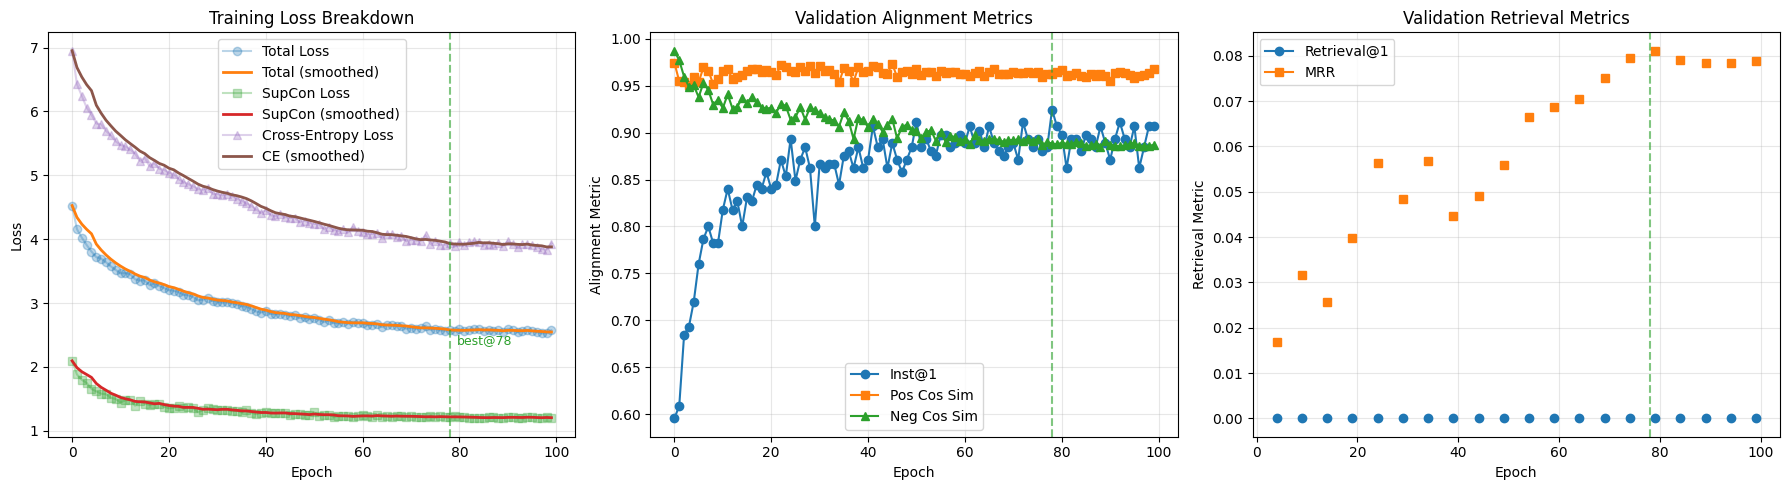

✅ Saved training curves to runs/training_curves.png


In [25]:
import matplotlib.pyplot as plt
import numpy as np

history_df = pd.DataFrame(history)
if history_df.empty:
    print("⚠️  No training history captured; skipping visualization.")
else:
    history_df = history_df.sort_values('epoch').reset_index(drop=True)
    history_df['loss_smooth'] = history_df['train_loss'].rolling(window=5, min_periods=1).mean()
    history_df['supcon_smooth'] = history_df['supcon_loss'].rolling(window=5, min_periods=1).mean()
    history_df['ce_smooth'] = history_df['ce_loss'].rolling(window=5, min_periods=1).mean()
    best_idx = history_df['val_inst_top1'].idxmax()
    best_epoch = int(history_df.loc[best_idx, 'epoch'])

    has_retrieval_cols = {'val_retrieval_top1', 'val_retrieval_mrr'} & set(history_df.columns)
    retrieval_available = False
    if has_retrieval_cols:
        retrieval_available = history_df[list(has_retrieval_cols)].notna().any().any()

    n_cols = 3 if retrieval_available else 2
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5))
    if n_cols == 1:
        axes = [axes]

    # Training + component losses
    ax_loss = axes[0]
    ax_loss.plot(history_df['epoch'], history_df['train_loss'], marker='o', label='Total Loss', alpha=0.3)
    ax_loss.plot(history_df['epoch'], history_df['loss_smooth'], label='Total (smoothed)', linewidth=2)
    ax_loss.plot(history_df['epoch'], history_df['supcon_loss'], marker='s', label='SupCon Loss', alpha=0.3)
    ax_loss.plot(history_df['epoch'], history_df['supcon_smooth'], label='SupCon (smoothed)', linewidth=2)
    ax_loss.plot(history_df['epoch'], history_df['ce_loss'], marker='^', label='Cross-Entropy Loss', alpha=0.3)
    ax_loss.plot(history_df['epoch'], history_df['ce_smooth'], label='CE (smoothed)', linewidth=2)
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Training Loss Breakdown')
    ax_loss.grid(alpha=0.3)
    ax_loss.legend()
    ax_loss.axvline(best_epoch, color='tab:green', linestyle='--', alpha=0.6)
    ax_loss.annotate(
        f"best@{best_epoch}",
        xy=(best_epoch, history_df.loc[best_idx, 'loss_smooth']),
        xytext=(5, -10),
        textcoords='offset points',
        color='tab:green',
        fontsize=9
    )

    # Alignment metrics
    ax_align = axes[1]
    ax_align.plot(history_df['epoch'], history_df['val_inst_top1'], marker='o', label='Inst@1')
    ax_align.plot(history_df['epoch'], history_df['val_pos_sim'], marker='s', label='Pos Cos Sim')
    ax_align.plot(history_df['epoch'], history_df['val_neg_sim'], marker='^', label='Neg Cos Sim')
    ax_align.axvline(best_epoch, color='tab:green', linestyle='--', alpha=0.6)
    ax_align.set_xlabel('Epoch')
    ax_align.set_ylabel('Alignment Metric')
    ax_align.set_title('Validation Alignment Metrics')
    ax_align.legend()
    ax_align.grid(alpha=0.3)

    if retrieval_available:
        ax_ret = axes[2]
        retrieval_cols = [col for col in ['val_retrieval_top1', 'val_retrieval_mrr'] if col in history_df.columns]
        retrieval_df = history_df[['epoch'] + retrieval_cols].dropna(how='all')
        if retrieval_df.empty:
            ax_ret.text(0.5, 0.5, 'No retrieval metrics yet', ha='center', va='center')
            ax_ret.axis('off')
        else:
            if 'val_retrieval_top1' in retrieval_df:
                ax_ret.plot(retrieval_df['epoch'], retrieval_df['val_retrieval_top1'], marker='o', label='Retrieval@1')
            if 'val_retrieval_mrr' in retrieval_df:
                ax_ret.plot(retrieval_df['epoch'], retrieval_df['val_retrieval_mrr'], marker='s', label='MRR')
            ax_ret.set_xlabel('Epoch')
            ax_ret.set_ylabel('Retrieval Metric')
            ax_ret.set_title('Validation Retrieval Metrics')
            ax_ret.legend()
            ax_ret.grid(alpha=0.3)
            ax_ret.axvline(best_epoch, color='tab:green', linestyle='--', alpha=0.6)

    plt.tight_layout()
    fig_path = Path(OUT_DIR) / 'training_curves.png'
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print(f"✅ Saved training curves to {fig_path}")

In [26]:
print("\n" + "=" * 70)
print("📊 TRAINING SUMMARY")
print("=" * 70)

print(f"\n📁 Output directory: {OUT_DIR}")
print(f"\n📈 Best performance:")
print(f"   Inst@1: {max(h['val_inst_top1'] for h in history):.3f}")
print(f"   Pos Cos Sim: {max(h['val_pos_sim'] for h in history):.3f}")
print(f"   Neg Cos Sim (min): {min(h['val_neg_sim'] for h in history):.3f}")
print(f"   Lowest SupCon Loss: {min(h['supcon_loss'] for h in history):.4f}")
print(f"   Lowest CE Loss: {min(h['ce_loss'] for h in history):.4f}")

decoder_wers = [h.get('val_decoder_wer') for h in history if h.get('val_decoder_wer') is not None and not math.isnan(h.get('val_decoder_wer'))]
decoder_bleus = [h.get('val_decoder_bleu') for h in history if h.get('val_decoder_bleu') is not None and not math.isnan(h.get('val_decoder_bleu'))]
decoder_exact = [h.get('val_decoder_exact') for h in history if h.get('val_decoder_exact') is not None and not math.isnan(h.get('val_decoder_exact'))]
if decoder_wers:
    print(f"   Decoder WER (min): {min(decoder_wers):.3f}")
if decoder_bleus:
    print(f"   Decoder BLEU (max): {max(decoder_bleus):.3f}")
if decoder_exact:
    print(f"   Decoder Exact (max): {max(decoder_exact):.3f}")

retrieval_scores = []
retrieval_mrrs = []
for h in history:
    if 'val_retrieval_top1' in h and h['val_retrieval_top1'] is not None and not math.isnan(h['val_retrieval_top1']):
        retrieval_scores.append(h['val_retrieval_top1'])
    if 'val_retrieval_mrr' in h and h['val_retrieval_mrr'] is not None and not math.isnan(h['val_retrieval_mrr']):
        retrieval_mrrs.append(h['val_retrieval_mrr'])
if retrieval_scores:
    print(f"   Retrieval@1: {max(retrieval_scores):.3f}")
if retrieval_mrrs:
    print(f"   Retrieval MRR: {max(retrieval_mrrs):.3f}")

print(f"\n📦 Generated files:")
files = [
    "best_model_top1_*.pt",
    "embeddings.npy",
    "embeddings_map.csv",
    "prototypes.npz",
    "sign_encoder.onnx",
    "sign_encoder.ts",
    "model_config.json",
    "sign_encoder_bundle.zip",
    "export_manifest.json",
    "training_history.csv",
    "training_curves.png"
 ]
for f in files:
    print(f"   ✓ {f}")

print(f"\n🚀 Next steps:")
print(f"   1. Validate DTW + prototype gating on additional webcam clips")
print(f"   2. Stress-test inference thresholds against negative samples")
print(f"   3. Integrate refreshed ONNX + TorchScript bundle into the service layer")
print(f"   4. Re-tune thresholds if deploying to new camera setups")

print("\n" + "=" * 70)


📊 TRAINING SUMMARY

📁 Output directory: ./runs

📈 Best performance:
   Inst@1: 0.924
   Pos Cos Sim: 0.974
   Neg Cos Sim (min): 0.885
   Lowest SupCon Loss: 1.1952
   Lowest CE Loss: 3.8359
   Decoder WER (min): 0.863
   Decoder BLEU (max): 0.043
   Decoder Exact (max): 0.000
   Retrieval@1: 0.000
   Retrieval MRR: 0.081

📦 Generated files:
   ✓ best_model_top1_*.pt
   ✓ embeddings.npy
   ✓ embeddings_map.csv
   ✓ prototypes.npz
   ✓ sign_encoder.onnx
   ✓ sign_encoder.ts
   ✓ model_config.json
   ✓ sign_encoder_bundle.zip
   ✓ export_manifest.json
   ✓ training_history.csv
   ✓ training_curves.png

🚀 Next steps:
   1. Validate DTW + prototype gating on additional webcam clips
   2. Stress-test inference thresholds against negative samples
   3. Integrate refreshed ONNX + TorchScript bundle into the service layer
   4. Re-tune thresholds if deploying to new camera setups

